In [1]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

import warnings
warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if not os.path.exists('models1'):
    os.mkdir('models1')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [3]:
data_path = '../input/lish-moa/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger(nb_name[:-6])
logger.info(f'file_name: {nb_name[:-6]}')
logger.info(f'Time: {time.ctime()}')
logger.info(f'Set seed: {SEED}')

file_name: 01_baseline-opt-OneCycle-wd
Time: Wed Nov 18 01:45:31 2020
Set seed: 777


# load df

In [5]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [6]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
14261  id_a6a4f3626  trt_cp       24      D2 -0.3265  0.1577 -0.3381  0.1789   
14266  id_a6b456ebb  trt_cp       24      D1 -0.7239  0.0713  0.2250  0.5864   
5119   id_3bd739795  trt_cp       24      D1  0.5283  1.2350  2.7150 -0.0206   
692    id_07b7426b2  trt_cp       24      D1 -0.2856 -0.6573  1.8890 -0.3083   
6833   id_4fbf1ada4  trt_cp       72      D2  0.9492 -0.5027 -0.0934 -2.2830   
7051   id_52620ac73  trt_cp       24      D1 -0.4717 -0.2592 -0.5129  0.0462   
13131  id_995a3b2d4  trt_cp       48      D1  2.4190 -1.1380 -0.4596 -0.1602   
2435   id_1c33757b3  trt_cp       24      D1 -0.0171 -0.0432 -0.4036 -0.6486   
10021  id_7514b50fb  trt_cp       48      D1  0.5772  0.8006  1.5080 -0.8161   
13768  id_a0ad27715  trt_cp       48      D2  0.2120  0.2485  1.0300 -1.0730   
18518  id_d7bb3adc4  trt_cp       48      D1 -0.7536 -0.5321 -0.1516 -0.0495   
20041  id_e91fab646  trt_cp       72      D2 -0.6309  0.4781 -2.6910  0.2385   
18117  id_d31c9e94e  trt_cp       48      D1  0.7976  1.0440  0.2952 -0.5905   
15504  id_b4cc111bb  trt_cp       48      D1 -0.5976 -1.1690 -0.4103  0.5798   
5556   id_412140e64  trt_cp       24      D1 -0.5952 -0.9559  2.4630 -0.0315   
21588  id_fbd8dbcad  trt_cp       72      D2 -0.2161 -1.4290  0.4589  1.0030   
15360  id_b31db9325  trt_cp       48      D1 -0.0374 -1.0160  1.9580 -0.4785   
11138  id_821c17c40  trt_cp       24      D2 -0.0261  0.1104 -0.1617 -0.3219   
8190   id_60006934f  trt_cp       48      D1  0.1364 -1.3170 -0.8553  0.1797   
2259   id_1a17c635a  trt_cp       72      D1 -1.0280 -0.8049 -1.0320  0.1032   

          g-4     g-5  ...  tropomyosin_receptor_kinase_inhibitor  \
14261  0.2595  0.7117  ...                                      0   
14266  2.6280 -0.4762  ...                                      0   
5119   0.5865  0.2824  ...                                      0   
692   -0.5899  0.5369  ...                                      0   
6833  -0.1903  0.0230  ...                                      0   
7051   0.5863 -0.6585  ...                                      0   
13131  2.5480  1.5230  ...                                      0   
2435  -0.7183 -0.5947  ...                                      0   
10021 -0.1879 -0.1965  ...                                      0   
13768 -0.0180 -1.7210  ...                                      0   
18518  1.0390  0.0809  ...                                      0   
20041 -0.3716 -1.7600  ...                                      0   
18117 -0.1289 -0.0398  ...                                      0   
15504 -1.1120 -0.5922  ...                                      0   
5556  -1.1080 -0.4219  ...                                      1   
21588 -0.4092 -0.3814  ...                                      0   
15360 -1.9240  0.4834  ...                                      0   
11138 -0.3690 -0.3912  ...                                      0   
8190  -0.3682  0.3688  ...                                      0   
2259  -1.0780  0.4771  ...                                      0   

       trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
14261             0                0                  0   
14266             0                0                  0   
5119              0                0                  0   
692               0                0                  0   
6833              0                0                  0   
7051              0                0                  0   
13131             0                0                  0   
2435              0                0                  0   
10021             0                0                  0   
13768             0                0                  0   
18518             0                0                  0   
20041             0                0                  0   
18117             0                0                  0   
15504             0                0                  0 

# cv

In [7]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [8]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [9]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [10]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [11]:
class CFG:
    max_grad_norm = 1000
    hidden_size = 256
    dropout = 0.5
    lr = 7e-3
    wd = 1e-3
    bs = 32
    epochs = 30
    smooth = 0.0005
    feature_cols = feature_cols
    target_cols = y_keys
    optimizer = None
    scheduler = None 

In [12]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.h1 = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size), 
            nn.Dropout(cfg.dropout))
        
        self.h2 = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
        )
        self.h3 = nn.Linear(cfg.hidden_size, len(cfg.target_cols))

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.h3(x)

In [13]:
def compute_metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(
        ys * np.log(preds + esp) + (1 - ys) * np.log(1 - preds + esp), axis=1),
                     axis=0)
    return score


def smoothing_critirion(smooth=0.0):
    assert 0 <= smooth < 1, 'smooth not in range'

    def smoothing(criterion):
        def warp(preds, ys):
            with torch.no_grad():
                ys = ys * (1.0 - smooth) + 0.5 * smooth
            return criterion(preds, ys)

        return warp

    return smoothing


@smoothing_critirion(smooth=CFG.smooth)
def criterion(preds, ys):
    return F.binary_cross_entropy_with_logits(preds, ys)

In [14]:
import torch_optimizer

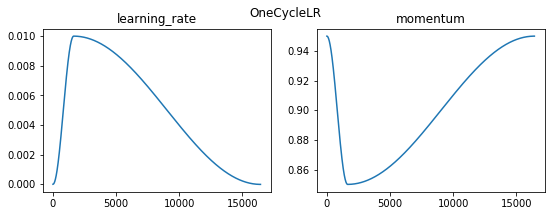

In [15]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = torch_optimizer.DiffGrad
CFG.optim_param = optim_param

scheduler_param = {
    'pct_start': 0.1,
    'div_factor': 1e3,
    'max_lr': 1e-2,
    'epochs': CFG.epochs,
    'pct_start':0.1,
    'final_div_factor':10000.0,
    'steps_per_epoch': len(trn_loader)
}
CFG.scheduler = optim.lr_scheduler.OneCycleLR
CFG.scheduler_param = scheduler_param


cfg = CFG
model = MLP(cfg).to(device)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* len(trn_loader)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)


show_learning_rate_scheduler()

# optimizer

In [16]:
from tabulate import tabulate
from colorama import Fore, Back, Style

version_higher = (torch.__version__ >= "1.5.0")

class AdaBelief(Optimizer):
    r"""Implements AdaBelief algorithm. Modified from Adam in PyTorch
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-16)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
        weight_decouple (boolean, optional): ( default: True) If set as True, then
            the optimizer uses decoupled weight decay as in AdamW
        fixed_decay (boolean, optional): (default: False) This is used when weight_decouple
            is set as True.
            When fixed_decay == True, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay$.
            When fixed_decay == False, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay \times lr$. Note that in this case, the
            weight decay ratio decreases with learning rate (lr).
        rectify (boolean, optional): (default: True) If set as True, then perform the rectified
            update similar to RAdam
        degenerated_to_sgd (boolean, optional) (default:True) If set as True, then perform SGD update
            when variance of gradient is high
    reference: AdaBelief Optimizer, adapting stepsizes by the belief in observed gradients, NeurIPS 2020
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-16,
                 weight_decay=0,
                 amsgrad=False,
                 weight_decouple=True,
                 fixed_decay=False,
                 rectify=True,
                 degenerated_to_sgd=True):

        # ------------------------------------------------------------------------------
        # Print modifications to default arguments
        print(
            Fore.RED +
            'Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.'
        )
        print(Fore.RED + 'Modifications to default arguments:')
        default_table = tabulate(
            [['adabelief-pytorch=0.0.5', '1e-8', 'False', 'False'],
             ['Current version (0.1.0)', '1e-16', 'True', 'True']],
            headers=['eps', 'weight_decouple', 'rectify'])
        print(Fore.RED + default_table)

        print(Fore.RED +
              'For a complete table of recommended hyperparameters, see')
        print(Fore.RED +
              'https://github.com/juntang-zhuang/Adabelief-Optimizer')

        print(Style.RESET_ALL)
        # ------------------------------------------------------------------------------

        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad,
                        buffer=[[None, None, None] for _ in range(10)])
        super(AdaBelief, self).__init__(params, defaults)

        self.degenerated_to_sgd = degenerated_to_sgd
        self.weight_decouple = weight_decouple
        self.rectify = rectify
        self.fixed_decay = fixed_decay
        if self.weight_decouple:
            print('Weight decoupling enabled in AdaBelief')
            if self.fixed_decay:
                print('Weight decay fixed')
        if self.rectify:
            print('Rectification enabled in AdaBelief')
        if amsgrad:
            print('AMSGrad enabled in AdaBelief')

    def __setstate__(self, state):
        super(AdaBelief, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def reset(self):
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                amsgrad = group['amsgrad']

                # State initialization
                state['step'] = 0
                # Exponential moving average of gradient values
                state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                # Exponential moving average of squared gradient values
                state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                if amsgrad:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdaBelief does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                beta1, beta2 = group['betas']

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                            if version_higher else torch.zeros_like(p.data)

                # get current state variable
                exp_avg, exp_avg_var = state['exp_avg'], state['exp_avg_var']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                # Update first and second moment running average
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                grad_residual = grad - exp_avg
                exp_avg_var.mul_(beta2).addcmul_(grad_residual,
                                                 grad_residual,
                                                 value=1 - beta2)

                if amsgrad:
                    max_exp_avg_var = state['max_exp_avg_var']
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_var,
                              exp_avg_var,
                              out=max_exp_avg_var)

                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                # perform weight decay, check if decoupled weight decay
                if self.weight_decouple:
                    if not self.fixed_decay:
                        p.data.mul_(1.0 - group['lr'] * group['weight_decay'])
                    else:
                        p.data.mul_(1.0 - group['weight_decay'])
                else:
                    if group['weight_decay'] != 0:
                        grad.add_(p.data, alpha=group['weight_decay'])

                # update
                if not self.rectify:
                    # Default update
                    step_size = group['lr'] / bias_correction1
                    p.data.addcdiv_(exp_avg, denom, value=-step_size)

                else:  # Rectified update, forked from RAdam
                    buffered = group['buffer'][int(state['step'] % 10)]
                    if state['step'] == buffered[0]:
                        N_sma, step_size = buffered[1], buffered[2]
                    else:
                        buffered[0] = state['step']
                        beta2_t = beta2**state['step']
                        N_sma_max = 2 / (1 - beta2) - 1
                        N_sma = N_sma_max - 2 * state['step'] * beta2_t / (
                            1 - beta2_t)
                        buffered[1] = N_sma

                        # more conservative since it's an approximated value
                        if N_sma >= 5:
                            step_size = math.sqrt(
                                (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                                (N_sma - 2) / N_sma * N_sma_max /
                                (N_sma_max - 2)) / (1 - beta1**state['step'])
                        elif self.degenerated_to_sgd:
                            step_size = 1.0 / (1 - beta1**state['step'])
                        else:
                            step_size = -1
                        buffered[2] = step_size

                    if N_sma >= 5:
                        denom = exp_avg_var.sqrt().add_(group['eps'])
                        p.data.addcdiv_(exp_avg,
                                        denom,
                                        value=-step_size * group['lr'])
                    elif step_size > 0:
                        p.data.add_(exp_avg, alpha=-step_size * group['lr'])

        return loss

In [17]:
class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss


class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss
    

def Ranger(params, alpha=0.5, k=6, *args, **kwargs):
    radam = RAdam(params, *args, **kwargs)
    return Lookahead(radam, alpha, k)


def RangerLars(params, alpha=0.5, k=6, *args, **kwargs):
    ralamb = Ralamb(params, *args, **kwargs)
    return Lookahead(ralamb, alpha, k)

In [18]:
# CG
# https://github.com/Yonghongwei/Gradient-Centralization
def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
    return x

class Adam_CG(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 amsgrad=False,
                 use_gc=False,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(Adam_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(Adam_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1
                #GC operation
                G_grad = exp_avg / denom
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class AdamW_CG(Optimizer):
    r"""Implements AdamW algorithm.
    The original Adam algorithm was proposed in `Adam: A Method for Stochastic Optimization`_.
    The AdamW variant was proposed in `Decoupled Weight Decay Regularization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay coefficient (default: 1e-2)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=1e-2,
                 amsgrad=False,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(AdamW_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(AdamW_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdamW does not support sparse gradients')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                #GC operation and stepweight decay
                G_grad = (exp_avg / denom).add(p.data,
                                               alpha=group['weight_decay'])
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class PlainRAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                beta2_t = beta2**state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] * math.sqrt(
                        (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                        (N_sma - 2) / N_sma * N_sma_max /
                        (N_sma_max - 2)) / (1 - beta1**state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom

                elif self.degenerated_to_sgd:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] / (1 - beta1**state['step'])
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p.data, alpha=group['weight_decay'])

                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class RAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        buffer=[[None, None, None] for _ in range(10)])
        super(RAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 -
                                                                       beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                elif step_size > 0:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)
                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class Ranger_CG(Optimizer):
    def __init__(
            self,
            params,
            lr=1e-3,  # lr
            alpha=0.5,
            k=6,
            N_sma_threshhold=5,  # Ranger options
            betas=(.95, 0.999),
            eps=1e-5,
            weight_decay=0,  # Adam options
            # Gradient centralization on or off, applied to conv layers only or conv + fc layers
            use_gc=True,
            gc_conv_only=False,
            gc_loc=False):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr,
                        alpha=alpha,
                        k=k,
                        step_counter=0,
                        betas=betas,
                        N_sma_threshhold=N_sma_threshhold,
                        eps=eps,
                        weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}"
        )
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(
                        state
                ) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                #if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    buffered[2] = step_size

                #if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [19]:
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {(id(k) if isinstance(k, torch.Tensor) else k): v
                      for k, v in self.state.items()}
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print(
                'Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups':
            state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)


def LookaheadAdam(params, alpha=0.5, k=6, *args, **kwargs):
    adam = optim.Adam(params, *args, **kwargs)
    return Lookahead(adam, alpha, k)  

def LookaheadAdam_CG(params, alpha=0.5, k=6, *args, **kwargs):
    adam = Adam_CG(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadAdamW(params, alpha=0.5, k=6, *args, **kwargs):
    adam = AdamW(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadDiffGrad(params, alpha=0.5, k=6, *args, **kwargs):
    diffgrad = torch_optimizer.DiffGrad(params, *args, **kwargs)
    return Lookahead(diffgrad, alpha, k)


def LookaheadYogi(params, alpha=0.5, k=6, *args, **kwargs):
    yogi = torch_optimizer.Yogi(params, *args, **kwargs)
    return Lookahead(yogi, alpha, k)

In [20]:
optim_list = [
    Adam_CG, AdamW_CG, PlainRAdam_CG, RAdam_CG, Ranger_CG,
    AdaBelief, torch_optimizer.AdaBound, torch_optimizer.AdaMod, AdamW,
    torch_optimizer.AdamP, torch_optimizer.DiffGrad, torch_optimizer.Lamb,
    torch_optimizer.NovoGrad, PlainRAdam, torch_optimizer.QHAdam, RAdam,
    Ranger, torch_optimizer.RangerQH, torch_optimizer.RangerVA,
    torch_optimizer.SWATS, torch_optimizer.Yogi, torch.optim.Adam, LookaheadAdam,
     LookaheadDiffGrad, LookaheadYogi, LookaheadAdamW
]

# train

In [21]:
def trn_fn(trn_loader, model, optimizer, scheduler, mb, history):

    running_loss = 0.0
    running_metric = 0.0
    m = 0

    model.train()

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (xs, ys) in enumerate(trn_tqdm):
        batch_size = len(xs)
        m += batch_size

        # forward, backward
        optimizer.zero_grad()
        preds = model(xs)
        loss = criterion(preds, ys)
        loss.backward()

        # clip grad
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        optimizer.step()
        if scheduler.__class__.__name__ == 'OneCycleLR':
            history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.step() 

        # metric
        metric = compute_metric(preds.sigmoid().detach().cpu().numpy(), 
                                ys.detach().cpu().numpy())
        

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, ' f'metric={metric:.4f}')
    
    # step if lr scheduler not onecycle
    if scheduler.__class__.__name__ != 'OneCycleLR':
        history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step()    
        
    return running_loss / m, running_metric / m


def val_fn(val_loader, model, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0
    val_preds = []

    model.eval()
    
    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (xs, ys) in enumerate(val_tqdm):

        batch_size = len(xs)
        m += batch_size

        model.eval()

        # loss
        with torch.no_grad():
            preds = model(xs)
        loss = criterion(preds, ys)
        
        # metric
        preds = preds.sigmoid()
        metric = compute_metric(preds.detach().cpu().numpy(),
                                ys.detach().cpu().numpy())

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size
        val_preds.append(preds.detach().cpu().numpy())

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, '
                            f'val_metric={metric:.4f}')
        
    val_preds = np.concatenate(val_preds)
    return running_loss / m, running_metric / m, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)
        
        pred = pred.sigmoid()
        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def plot_history(history, fold_num=0):
    
    fig = plt.figure(figsize=(16, 3))
    fig.subplots_adjust(top=0.8)
    plt.suptitle(f'fold{fold_num}')
    
    # metrics
    plt.subplot(131)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_metrics'], 'C0', label='train')
    plt.plot(history['val_metrics'], 'C1', label='val')
    plt.title(f'Metric')
    plt.legend()
    plt.ylabel("Metric") 
    plt.xlabel("Epoch")
    
    # loss
    plt.subplot(132)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_losses'], 'C0', label='train')
    plt.plot(history['val_losses'], 'C1', label='val')
    plt.title(f'Loss')
    plt.legend()
    plt.ylabel("Loss") 
    plt.xlabel("Epoch")
    
    # lr
    plt.subplot(133)
    plt.plot(history['lrs'][1:], 'C0', label='lr')
    plt.title(f'Learning rate')
    plt.ylabel("Loss") 
    if history['lrs'] == 'OneCycleLR':
        plt.xlabel("Iteration")    
    else:
        plt.xlabel("Epoch")
    
    plt.show()

In [22]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):
    
    # init
    best_loss = np.inf
    history = {
        'losses': [],
        'trn_losses': [],
        'trn_metrics': [],
        'val_losses': [],
        'val_metrics': [],
        'lrs': [],
    }
    mb = master_bar(range(1, cfg.epochs + 1))
    mb.write(('epoch', 'train loss', 'train metric', 'val loss', 'val metric',
              'time'),
             table=True)

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
    scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)
    history['lrs'].append(scheduler.__class__.__name__)

    # train & validate
    for epoch in mb:
        start_time = time.time()
        trn_loss, trn_metric = trn_fn(trn_loader, 
                                      model, 
                                      optimizer, 
                                      scheduler,
                                      mb, 
                                      history)
        val_loss, val_metric, val_preds = val_fn(val_loader, model, mb)

        # checkpoint
        if val_metric < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_metric}')
            best_loss = val_metric
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")

        # calculate time
        end_time = time.time()
        m, s = divmod(end_time - start_time, 60)

        # record
        history['trn_losses'].append(trn_loss)
        history['trn_metrics'].append(trn_metric)
        history['val_losses'].append(val_loss)
        history['val_metrics'].append(val_metric)
        mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{trn_metric:.10f}',
                  f'{val_loss:.6f}', f'{val_metric:.10f}', f'{m:.0f}:{s:.0f}'),
                 table=True)

    score = compute_metric(oof[val_idx],
                           trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")
    plot_history(history, fold_num)

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    #model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))

    folds = MultilabelStratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):

        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

    score = compute_metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions


optimizer: Adam_CG
fold 0


epoch1 save best model... 0.03367969265933189
epoch2 save best model... 0.03191677752059114
epoch11 save best model... 0.031867050074872505
fold0 score: 0.03186705044222485


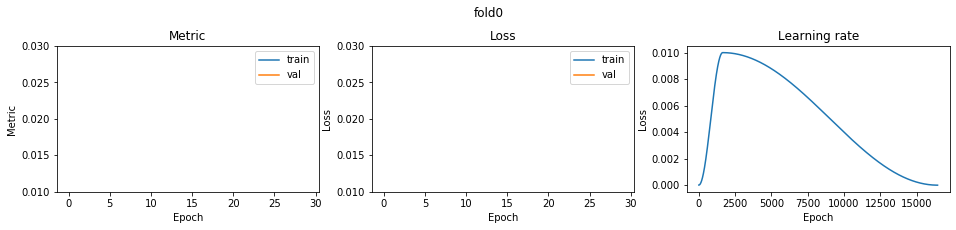

fold 1


epoch1 save best model... 0.03397170813806401
epoch2 save best model... 0.0315359695331807
fold1 score: 0.031535969527061565


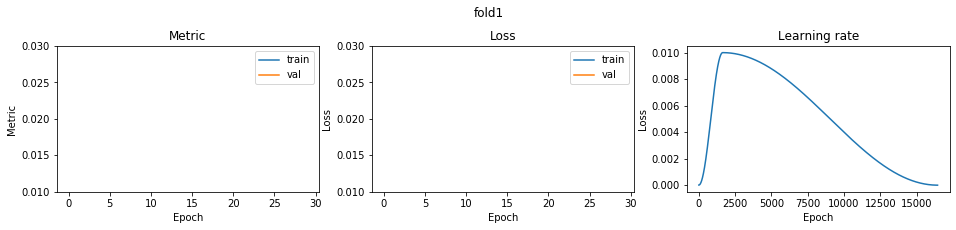

fold 2


epoch1 save best model... 0.035452490033763065
epoch2 save best model... 0.03168736817474367
fold2 score: 0.03168736831892829


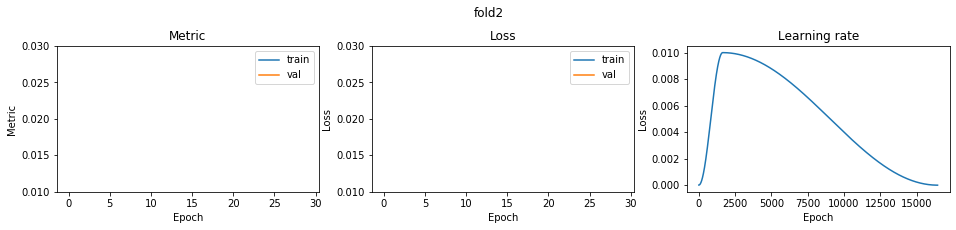

fold 3


epoch1 save best model... 0.034231025520245414
epoch2 save best model... 0.031628892675110036
fold3 score: 0.03162889279680074


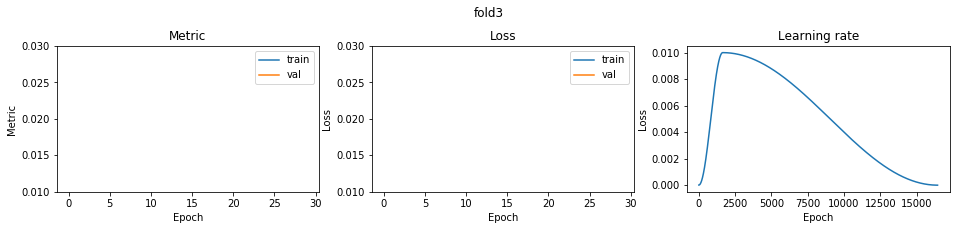

fold 4


epoch1 save best model... 0.03418024088126652
epoch2 save best model... 0.03145568701512857
fold4 score: 0.03145568711495874


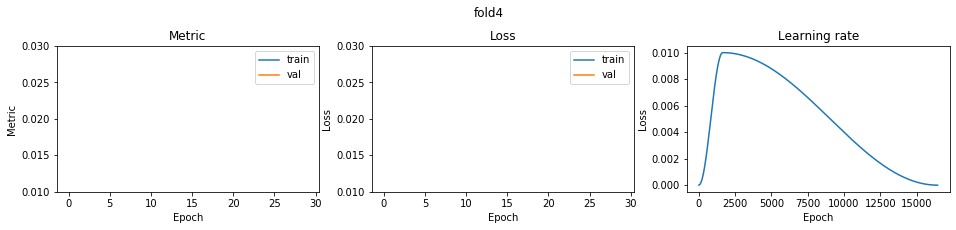

CV score: 0.03163499576544745

optimizer: AdamW_CG
fold 0


epoch1 save best model... 0.022214225570168472
epoch2 save best model... 0.019928690065589474
epoch3 save best model... 0.01884533677988416
epoch4 save best model... 0.018031848300935738
epoch5 save best model... 0.017691532048929252
epoch6 save best model... 0.017472353797397474
epoch7 save best model... 0.017354015197290917
epoch8 save best model... 0.017164174020120656
epoch9 save best model... 0.01705889491478919
epoch10 save best model... 0.01693430504504939
epoch12 save best model... 0.016821473653604337
epoch13 save best model... 0.016734644860572315
epoch14 save best model... 0.016693186911845532
epoch15 save best model... 0.016533887379533336
epoch17 save best model... 0.016492073163220444
epoch18 save best model... 0.01633972259734785
epoch21 save best model... 0.01627797733118295
fold0 score: 0.016277977241643087


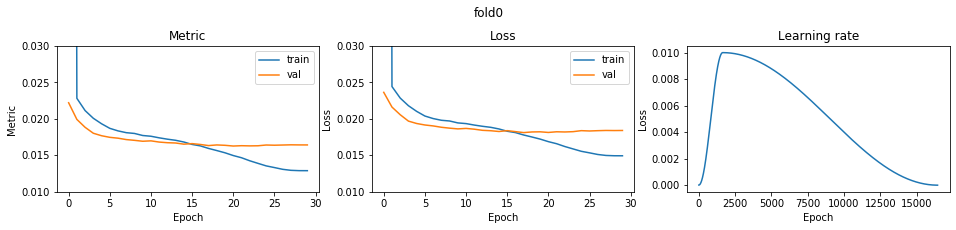

fold 1


epoch1 save best model... 0.022000083844539216
epoch2 save best model... 0.019276504582025435
epoch3 save best model... 0.01861952444613591
epoch4 save best model... 0.018491976659114336
epoch5 save best model... 0.017707325216178186
epoch6 save best model... 0.01744890941180056
epoch8 save best model... 0.01733858989690439
epoch10 save best model... 0.017247724477316286
epoch11 save best model... 0.017100683783301325
epoch13 save best model... 0.01704062449014399
epoch14 save best model... 0.016899423074298918
epoch15 save best model... 0.016828666949136692
epoch16 save best model... 0.016778684040842595
epoch17 save best model... 0.016653087612485105
epoch19 save best model... 0.016615798561495348
epoch23 save best model... 0.016598065668709812
fold1 score: 0.016598065505914767


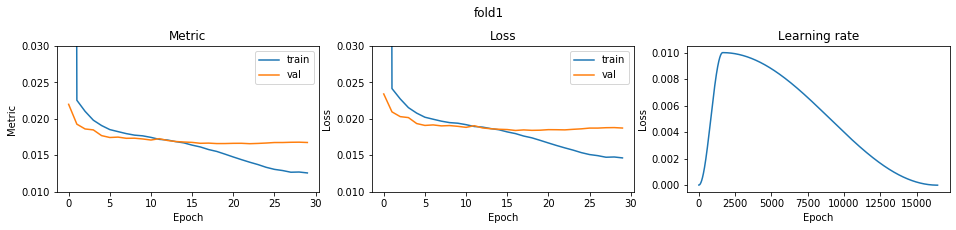

fold 2


epoch1 save best model... 0.02177098481331295
epoch2 save best model... 0.01961167571430877
epoch3 save best model... 0.018651334666467713
epoch4 save best model... 0.01786802339162376
epoch5 save best model... 0.017613211211676912
epoch6 save best model... 0.017454477075438995
epoch7 save best model... 0.01742727834138044
epoch8 save best model... 0.017377798552044528
epoch9 save best model... 0.017118773110572475
epoch10 save best model... 0.016984298560657175
epoch11 save best model... 0.016841847932496247
epoch12 save best model... 0.016827296169411487
epoch14 save best model... 0.01675988700284138
epoch15 save best model... 0.016693630541585035
epoch16 save best model... 0.016555899505474404
epoch17 save best model... 0.016426794329608498
epoch18 save best model... 0.01642313457628227
epoch19 save best model... 0.01634511397037495
epoch20 save best model... 0.01628178606982396
fold2 score: 0.016281786001086814


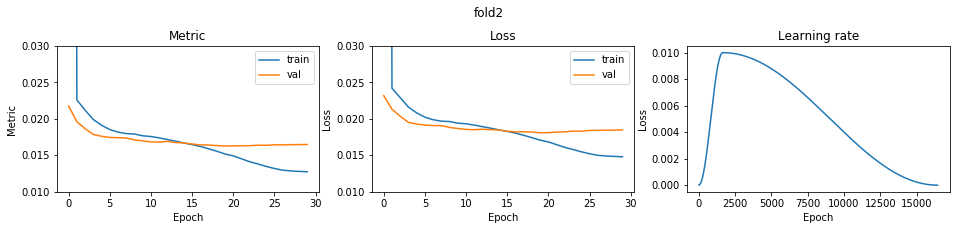

fold 3


epoch1 save best model... 0.022851043356612224
epoch2 save best model... 0.01959739799838267
epoch3 save best model... 0.018807123437235323
epoch4 save best model... 0.018029225591765313
epoch5 save best model... 0.017887659557588007
epoch6 save best model... 0.017655004465905844
epoch7 save best model... 0.017517375165770566
epoch8 save best model... 0.017410935769133388
epoch9 save best model... 0.017379231370374528
epoch10 save best model... 0.017302719388657795
epoch11 save best model... 0.017099471025355584
epoch12 save best model... 0.0170686464243333
epoch13 save best model... 0.01692023375336768
epoch14 save best model... 0.01682401038494156
epoch17 save best model... 0.016752941478765094
epoch19 save best model... 0.016648224924090647
epoch20 save best model... 0.01662393728258398
epoch21 save best model... 0.016497132910207626
fold3 score: 0.016497132923406405


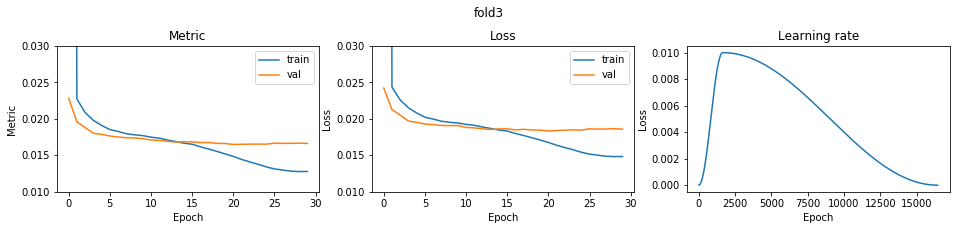

fold 4


epoch1 save best model... 0.021887650523241396
epoch2 save best model... 0.019486800504844116
epoch3 save best model... 0.01877033497145344
epoch4 save best model... 0.018130350708622053
epoch5 save best model... 0.01777610768625568
epoch6 save best model... 0.017654452889156368
epoch7 save best model... 0.01751585743583077
epoch8 save best model... 0.01728297044100889
epoch9 save best model... 0.0171045859410069
epoch10 save best model... 0.017103194887060375
epoch12 save best model... 0.016979530721410667
epoch13 save best model... 0.016955534241041317
epoch14 save best model... 0.016773514425836012
epoch15 save best model... 0.016752164683183805
epoch17 save best model... 0.016622236077429766
epoch18 save best model... 0.016553939032476556
epoch19 save best model... 0.01652801326244798
epoch22 save best model... 0.01648664471432397
epoch23 save best model... 0.01647957050897062
fold4 score: 0.01647957033304316


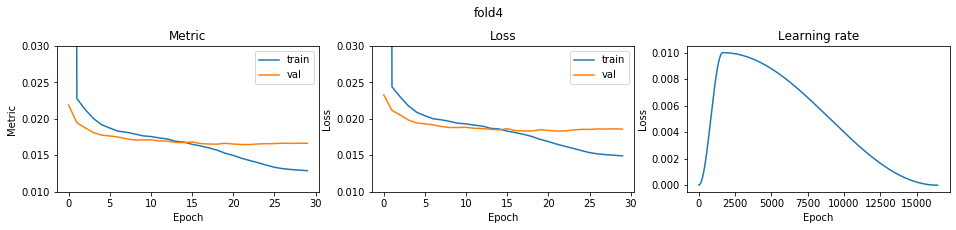

CV score: 0.016426905214637175

optimizer: PlainRAdam_CG
fold 0


epoch1 save best model... 0.7108753338761644
epoch2 save best model... 0.6954309716583112
epoch3 save best model... 0.626414559886776
epoch4 save best model... 0.33403649239170796
epoch5 save best model... 0.12147463494254136
epoch6 save best model... 0.05512616937144199
epoch7 save best model... 0.03521295805421397
epoch8 save best model... 0.02781823625478359
epoch9 save best model... 0.024084507352364906
epoch10 save best model... 0.022477747841922732
epoch11 save best model... 0.021485697584977724
epoch12 save best model... 0.020879241159707646
epoch13 save best model... 0.02059147090042235
epoch14 save best model... 0.02043313549869696
epoch15 save best model... 0.02025867241746608
epoch16 save best model... 0.02005393682790237
epoch18 save best model... 0.019898900149521632
epoch19 save best model... 0.019839739435456336
epoch20 save best model... 0.019780098099541555
epoch22 save best model... 0.019735178123981373
epoch25 save best model... 0.0197053760807783
epoch26 save best m

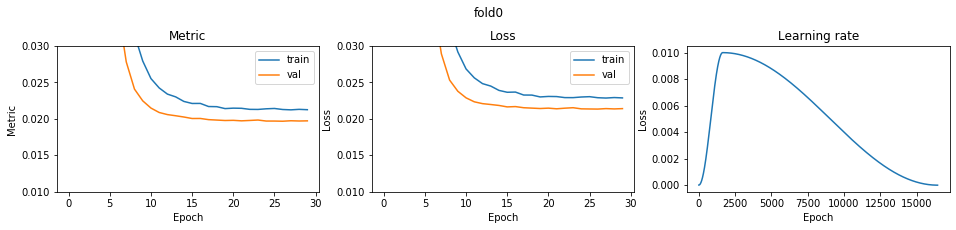

fold 1


epoch1 save best model... 0.71140769033721
epoch2 save best model... 0.6959061894500465
epoch3 save best model... 0.6249810046013246
epoch4 save best model... 0.33165351299903856
epoch5 save best model... 0.11874293531703906
epoch6 save best model... 0.055007045486367735
epoch7 save best model... 0.035151787303383024
epoch8 save best model... 0.027595630041214323
epoch9 save best model... 0.02421526994838832
epoch10 save best model... 0.022441621228974456
epoch11 save best model... 0.02161011212957587
epoch12 save best model... 0.02107180789364283
epoch13 save best model... 0.02076305437126038
epoch14 save best model... 0.020494938018952667
epoch15 save best model... 0.020372905080731026
epoch16 save best model... 0.020266385970513705
epoch17 save best model... 0.020114945590251614
epoch18 save best model... 0.020035577215649837
epoch19 save best model... 0.019917067392852508
epoch22 save best model... 0.019846808237458016
epoch23 save best model... 0.019816537240618153
epoch24 save be

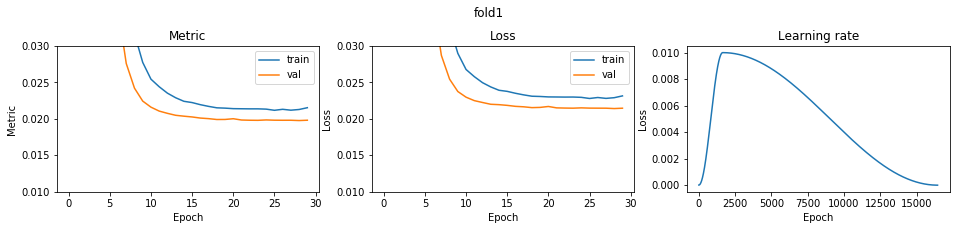

fold 2


epoch1 save best model... 0.7168577452215471
epoch2 save best model... 0.7005808880481776
epoch3 save best model... 0.6299478359253918
epoch4 save best model... 0.32857063579706
epoch5 save best model... 0.11893870532987981
epoch6 save best model... 0.054614468348015414
epoch7 save best model... 0.03437883047589438
epoch8 save best model... 0.026999130967294036
epoch9 save best model... 0.024032406517410364
epoch10 save best model... 0.022250853262045546
epoch11 save best model... 0.021486025232729185
epoch12 save best model... 0.020926682617601052
epoch13 save best model... 0.020566677660646297
epoch14 save best model... 0.020347000252286567
epoch15 save best model... 0.020129001250596218
epoch16 save best model... 0.020023343895767185
epoch17 save best model... 0.019909768559481702
epoch18 save best model... 0.01979609769568489
epoch21 save best model... 0.01972670977356752
epoch23 save best model... 0.019650662746505357
fold2 score: 0.019650662727264904


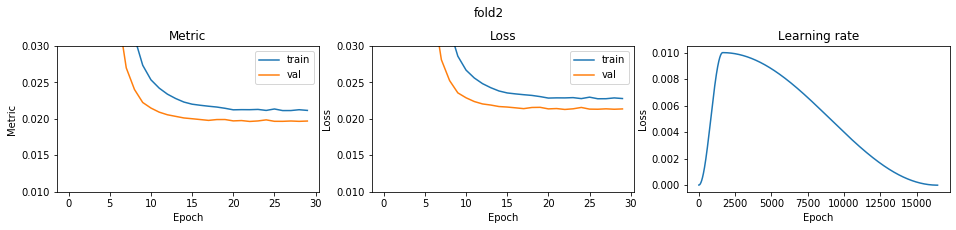

fold 3


epoch1 save best model... 0.7015076271493778
epoch2 save best model... 0.6902375866177414
epoch3 save best model... 0.6178453565186954
epoch4 save best model... 0.3283051941688077
epoch5 save best model... 0.11935227258398212
epoch6 save best model... 0.0558843056490997
epoch7 save best model... 0.03481732331946119
epoch8 save best model... 0.02745526640130746
epoch9 save best model... 0.024148225252238656
epoch10 save best model... 0.022619547425919893
epoch11 save best model... 0.02157843409186751
epoch12 save best model... 0.02115846094007101
epoch13 save best model... 0.020774340799294733
epoch14 save best model... 0.020582848449570715
epoch15 save best model... 0.020433726447691678
epoch16 save best model... 0.020249816586935983
epoch17 save best model... 0.020129937401936648
epoch18 save best model... 0.020070222564941117
epoch19 save best model... 0.02003578438438424
epoch20 save best model... 0.019951196187992574
epoch24 save best model... 0.01992952580307027
epoch25 save best 

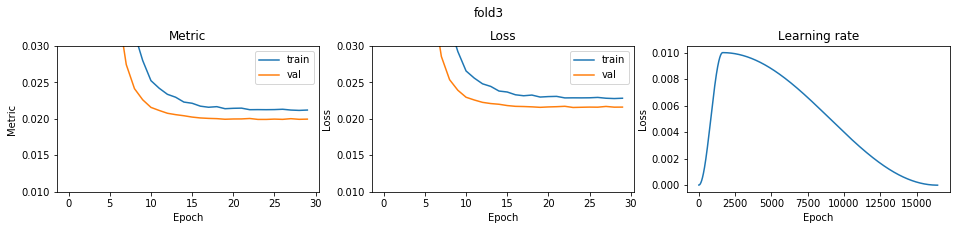

fold 4


epoch1 save best model... 0.7113764780257449
epoch2 save best model... 0.7000015503181684
epoch3 save best model... 0.6258354154154488
epoch4 save best model... 0.3298568893809525
epoch5 save best model... 0.11718014389072844
epoch6 save best model... 0.0543594404766527
epoch7 save best model... 0.03446491136892374
epoch8 save best model... 0.02708187860209741
epoch9 save best model... 0.023923756558117126
epoch10 save best model... 0.02209196620300446
epoch11 save best model... 0.021173370655855176
epoch12 save best model... 0.020708137453620688
epoch13 save best model... 0.02028588055291453
epoch14 save best model... 0.020107298092343812
epoch15 save best model... 0.01995637360917816
epoch16 save best model... 0.01979354116429229
epoch18 save best model... 0.019690825467280078
epoch19 save best model... 0.01955247912428645
epoch21 save best model... 0.019543103646308794
epoch23 save best model... 0.019527983005266796
epoch24 save best model... 0.019515292138998358
epoch25 save best m

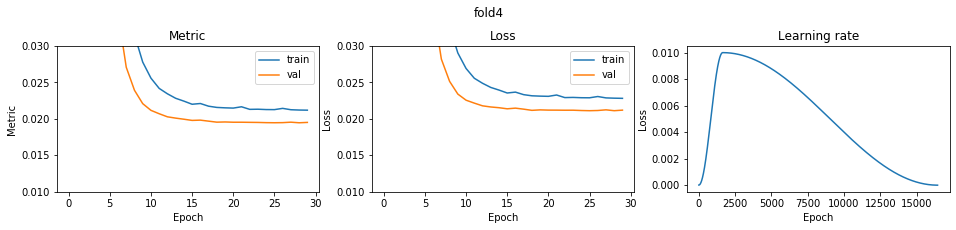

CV score: 0.019700691078425772

optimizer: RAdam_CG
fold 0


epoch1 save best model... 0.0365957931719364
epoch2 save best model... 0.01947896767806491
epoch3 save best model... 0.018428673926138388
epoch4 save best model... 0.017937377949748062
epoch5 save best model... 0.017782397025979734
epoch6 save best model... 0.017536145566638076
epoch7 save best model... 0.01722266847153188
epoch8 save best model... 0.01714395604060288
epoch9 save best model... 0.01707646660761301
epoch10 save best model... 0.01692805414370225
epoch11 save best model... 0.01685926984732542
epoch12 save best model... 0.016730631522172405
epoch13 save best model... 0.016729954602981753
epoch14 save best model... 0.01658535991415619
epoch16 save best model... 0.016435303351924602
epoch17 save best model... 0.01634102822970896
epoch18 save best model... 0.016302825707797987
epoch19 save best model... 0.016284005603581193
epoch20 save best model... 0.016211617537742324
epoch21 save best model... 0.016167792979551475
fold0 score: 0.016167792924564595


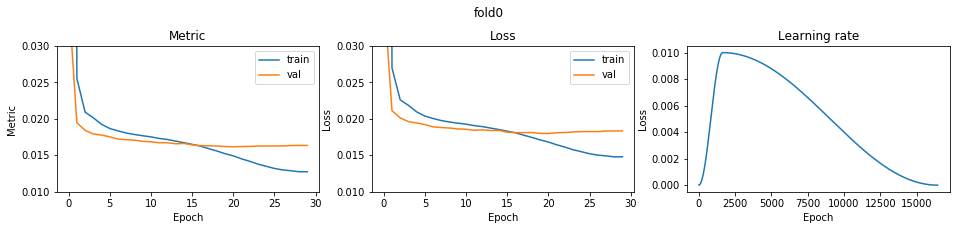

fold 1


epoch1 save best model... 0.036798990129793006
epoch2 save best model... 0.01960552305298885
epoch3 save best model... 0.019067714592167335
epoch4 save best model... 0.01812880749923068
epoch5 save best model... 0.017758793329345147
epoch6 save best model... 0.017655392759877448
epoch7 save best model... 0.017475281994196543
epoch8 save best model... 0.01739335309024022
epoch9 save best model... 0.017256073823029346
epoch10 save best model... 0.01711961635579197
epoch11 save best model... 0.017089444372822494
epoch12 save best model... 0.0170857817069117
epoch13 save best model... 0.017072553972389628
epoch14 save best model... 0.01693621966317313
epoch15 save best model... 0.0168868724789787
epoch16 save best model... 0.016670574301692085
epoch19 save best model... 0.01661198826047969
epoch20 save best model... 0.016598310663839506
epoch21 save best model... 0.016578992523802974
epoch22 save best model... 0.016525149110286214
fold1 score: 0.01652514893112611


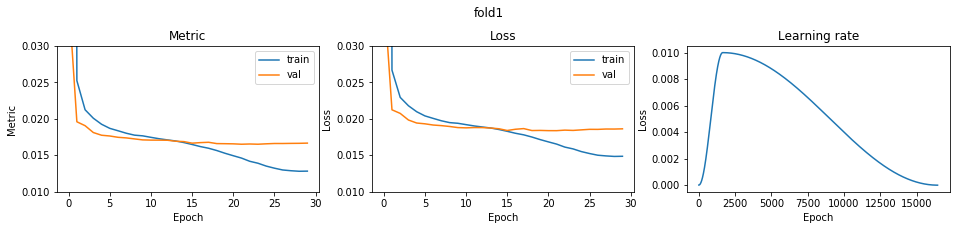

fold 2


epoch1 save best model... 0.03718222401684795
epoch2 save best model... 0.019881573485965528
epoch3 save best model... 0.019311276204861984
epoch4 save best model... 0.018003881869484973
epoch6 save best model... 0.01757645705155901
epoch7 save best model... 0.017427406678437563
epoch8 save best model... 0.017263331217532155
epoch9 save best model... 0.017221858806646707
epoch10 save best model... 0.0169504174088822
epoch13 save best model... 0.016690617906789922
epoch16 save best model... 0.016636128449083853
epoch17 save best model... 0.01649203230231138
epoch18 save best model... 0.01647887628005194
epoch19 save best model... 0.016464537787502623
epoch20 save best model... 0.016391082989986868
epoch22 save best model... 0.016361994100583935
fold2 score: 0.01636199398996208


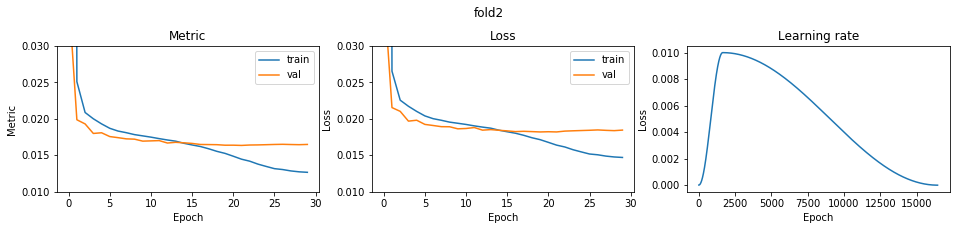

fold 3


epoch1 save best model... 0.03731470366681084
epoch2 save best model... 0.02003023463188923
epoch3 save best model... 0.01877399436739148
epoch4 save best model... 0.018086052229861326
epoch5 save best model... 0.017753532404559486
epoch6 save best model... 0.017709906529507904
epoch7 save best model... 0.017529215249137482
epoch8 save best model... 0.01735661018996209
epoch9 save best model... 0.01726785946280986
epoch10 save best model... 0.01714959835086298
epoch11 save best model... 0.017141225981973707
epoch12 save best model... 0.016977884300511357
epoch14 save best model... 0.016919298822607565
epoch15 save best model... 0.016779225372236247
epoch16 save best model... 0.016704914542360567
epoch17 save best model... 0.01670207428981408
epoch18 save best model... 0.01666900987921448
epoch19 save best model... 0.016619253185724072
epoch20 save best model... 0.016567421232717185
epoch21 save best model... 0.016548684307698645
epoch22 save best model... 0.016509074476761806
fold3 sco

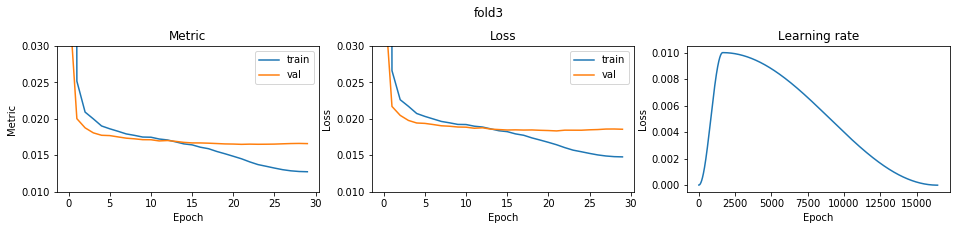

fold 4


epoch1 save best model... 0.03890813266973017
epoch2 save best model... 0.019473130909348404
epoch3 save best model... 0.01839497527256099
epoch4 save best model... 0.0180329812202679
epoch5 save best model... 0.017752078864171864
epoch6 save best model... 0.017574542632288297
epoch7 save best model... 0.01727247845873678
epoch9 save best model... 0.017242147181615878
epoch10 save best model... 0.01699788919172689
epoch12 save best model... 0.016970236060169265
epoch13 save best model... 0.016888730629752463
epoch14 save best model... 0.016839127188255684
epoch15 save best model... 0.016797433423561495
epoch16 save best model... 0.01660355976644844
epoch17 save best model... 0.016537112614950313
epoch19 save best model... 0.01646250794707439
epoch23 save best model... 0.016458115623181935
fold4 score: 0.016458115532915072


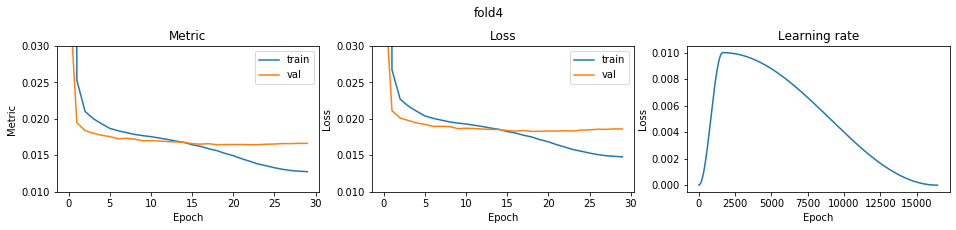

CV score: 0.016404421598843803

optimizer: Ranger_CG
fold 0


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.25631136599597193
epoch2 save best model... 0.020160569301498777
epoch3 save best model... 0.018894483973028176
epoch4 save best model... 0.018368194672302395
epoch5 save best model... 0.017920548353420575
epoch6 save best model... 0.017511727350312103
epoch7 save best model... 0.017192467461618042
epoch8 save best model... 0.017128538470163705
epoch9 save best model... 0.01688695145104768
epoch10 save best model... 0.01674230336752595
epoch12 save best model... 0.01661974814315252
epoch13 save best model... 0.016527399310422106
epoch14 save best model... 0.016408005019900196
epoch15 save best model... 0.016353914782337012
epoch16 save best model... 0.01627674614140819
epoch18 save best model... 0.016242816940306395
fold0 score: 0.016242816913378023


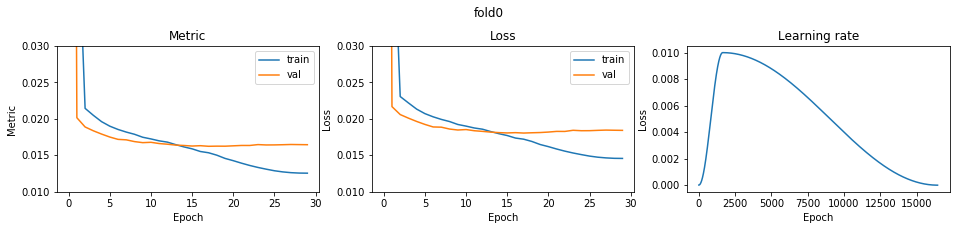

fold 1


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.2544660910940246
epoch2 save best model... 0.020481644132518094
epoch3 save best model... 0.018993811828705385
epoch4 save best model... 0.018196949972093146
epoch5 save best model... 0.017890435124678066
epoch6 save best model... 0.017455744745935944
epoch7 save best model... 0.017402808444426363
epoch9 save best model... 0.017067208411679177
epoch11 save best model... 0.01698399034487268
epoch13 save best model... 0.016858454217158612
epoch15 save best model... 0.016717557638958283
epoch16 save best model... 0.016701169737875055
epoch18 save best model... 0.016665573844906408
epoch19 save best model... 0.016635385460771347
fold1 score: 0.016635385444727955


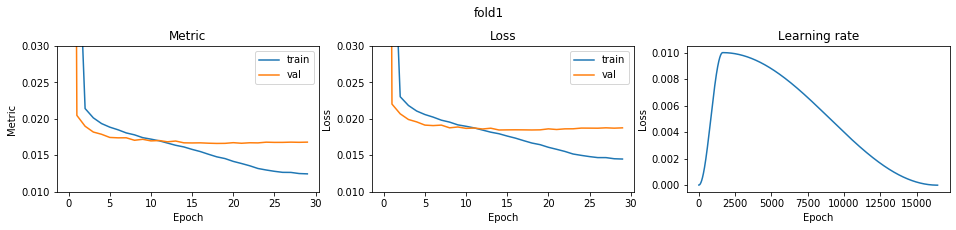

fold 2


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.24225655627239806
epoch2 save best model... 0.020299838465848742
epoch3 save best model... 0.018897563572374623
epoch4 save best model... 0.018188128665244083
epoch5 save best model... 0.017690555904655597
epoch6 save best model... 0.017520269840331032
epoch7 save best model... 0.0172997659968166
epoch8 save best model... 0.017252574540253692
epoch9 save best model... 0.017007841031992453
epoch10 save best model... 0.016896965574387416
epoch11 save best model... 0.016840981004861946
epoch12 save best model... 0.016684349407954366
epoch13 save best model... 0.016634080819165988
epoch14 save best model... 0.016561369136218588
epoch15 save best model... 0.01645914306721972
epoch16 save best model... 0.016382556946769503
epoch17 save best model... 0.016361693165412073
epoch18 save best model... 0.016342031836932395
fold2 score: 0.016342031807892295


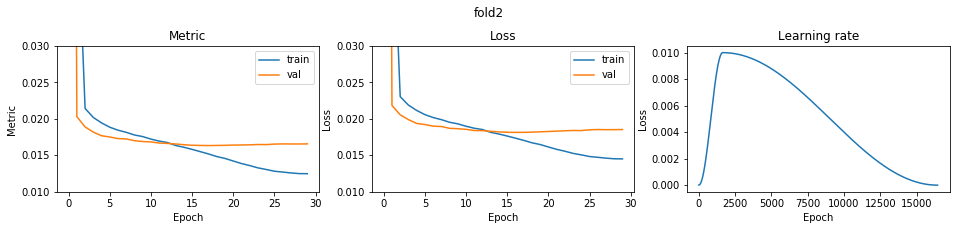

fold 3


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.24170725733245424
epoch2 save best model... 0.020696685473797397
epoch3 save best model... 0.019147895811579628
epoch4 save best model... 0.018498396585379346
epoch5 save best model... 0.018123932933362716
epoch6 save best model... 0.017771927997520816
epoch7 save best model... 0.017564675042189334
epoch8 save best model... 0.017475190911026235
epoch9 save best model... 0.01716503834899235
epoch10 save best model... 0.01708278844688843
epoch11 save best model... 0.017060353555599893
epoch12 save best model... 0.01682624876677379
epoch13 save best model... 0.016784483625008333
epoch14 save best model... 0.016709051026213822
epoch16 save best model... 0.016591937596016567
epoch17 save best model... 0.016529161313332295
epoch18 save best model... 0.016516170640961864
epoch19 save best model... 0.01649146365438819
epoch22 save best model... 0.01647489092658552
fold3 score: 0.016474890714923092


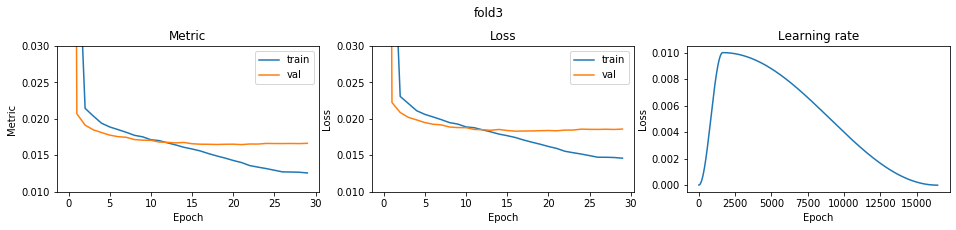

fold 4


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.2522168735029486
epoch2 save best model... 0.02042672966345975
epoch3 save best model... 0.018792898280032676
epoch4 save best model... 0.01807036069868841
epoch5 save best model... 0.017792910189794245
epoch6 save best model... 0.01742674894503621
epoch7 save best model... 0.017395751020427716
epoch8 save best model... 0.017295833847194842
epoch9 save best model... 0.0170626482669612
epoch10 save best model... 0.016888375793730072
epoch12 save best model... 0.016700416431679542
epoch14 save best model... 0.016620272898660433
epoch15 save best model... 0.016585546025501434
epoch16 save best model... 0.01650374824126041
epoch18 save best model... 0.01647269950038276
fold4 score: 0.01647269930514651


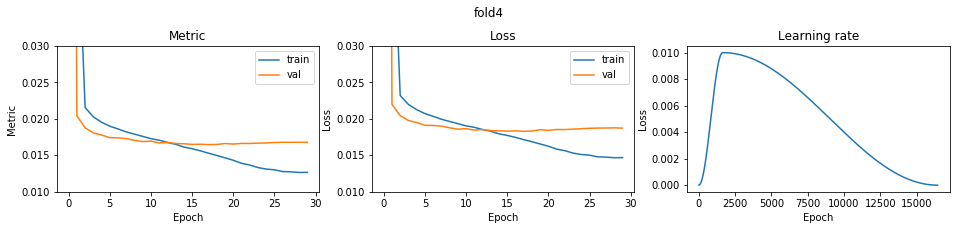

CV score: 0.016433559812264686

optimizer: AdaBelief
fold 0


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.021621756651916103
epoch2 save best model... 0.018700874724122005
epoch3 save best model... 0.018207890430893877
epoch4 save best model... 0.017793306820349162
epoch5 save best model... 0.017353526586857636
epoch6 save best model... 0.017293819606066563
epoch7 save best model... 0.01704931810650983
epoch8 save best model... 0.01703007256607939
epoch9 save best model... 0.016846552547194693
epoch11 save best model... 0.016775581872850182
epoch12 save best model... 0.016559564214462842
epoch14 save best model... 0.016537911452115396
epoch16 save best model... 0.01645495014303366
epoch17 save best model... 0.016428675483445506
epoch18 save best model... 0.016313640057090205
epoch19 save best model... 0.016292684175634165
epoch21 save best model... 0.016256935804114934
fold0 score: 0.016256935721933017


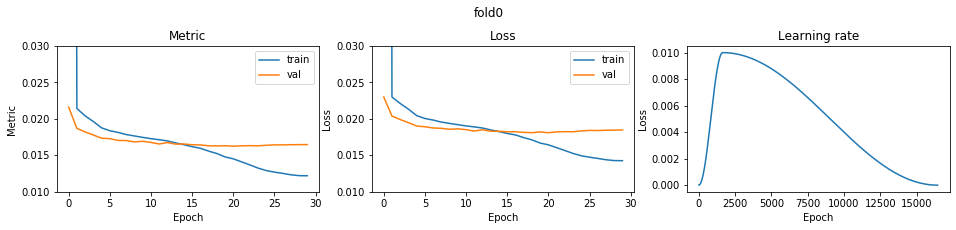

fold 1


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.021703090318401192
epoch2 save best model... 0.019104391420470143
epoch3 save best model... 0.018686116264365303
epoch4 save best model... 0.01805102432307512
epoch5 save best model... 0.017703303704825504
epoch6 save best model... 0.017631007234085717
epoch7 save best model... 0.01729582866077055
epoch10 save best model... 0.01705862221720347
epoch12 save best model... 0.016926415614303355
epoch14 save best model... 0.016832447195954843
epoch15 save best model... 0.016815907387650687
epoch16 save best model... 0.016743001620813366
epoch18 save best model... 0.01666459840238366
epoch19 save best model... 0.016602974882831904
epoch20 save best model... 0.016574078686170383
fold1 score: 0.016574078605587274


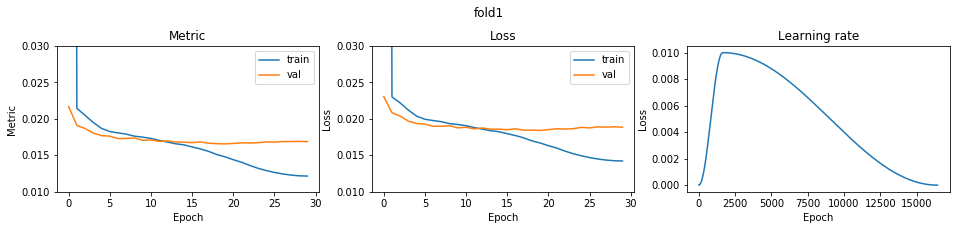

fold 2


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.021745571454549386
epoch2 save best model... 0.018889386843025047
epoch3 save best model... 0.018336178768000942
epoch4 save best model... 0.017992642738890962
epoch5 save best model... 0.017638445161512188
epoch7 save best model... 0.017331555461959594
epoch8 save best model... 0.017278061889190083
epoch9 save best model... 0.017140877158541252
epoch10 save best model... 0.016887099245521984
epoch12 save best model... 0.016820972966780135
epoch13 save best model... 0.01669607649598246
epoch14 save best model... 0.016662008984841527
epoch16 save best model... 0.01651262607226837
epoch17 save best model... 0.016455088102310306
epoch19 save best model... 0.01645191857414301
epoch20 save best model... 0.01635308809642926
epoch21 save best model... 0.01627296047388326
fold2 score: 0.016272960455564336


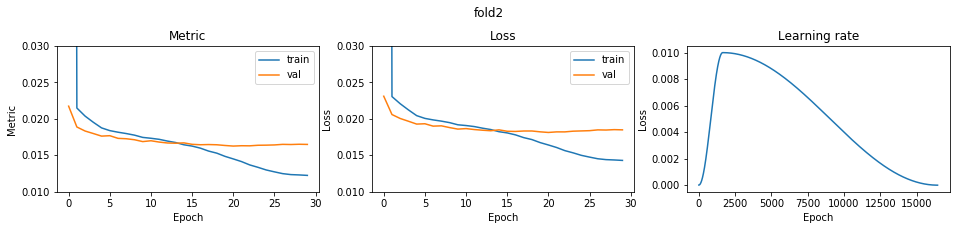

fold 3


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.021857775135945893
epoch2 save best model... 0.018883006536064496
epoch3 save best model... 0.018567239012832252
epoch4 save best model... 0.018118463439234705
epoch5 save best model... 0.0176951336014617
epoch6 save best model... 0.017651621766541163
epoch7 save best model... 0.0174411078210674
epoch8 save best model... 0.017399547336058762
epoch9 save best model... 0.017323135038528056
epoch10 save best model... 0.01716782650814852
epoch11 save best model... 0.01713792435434522
epoch12 save best model... 0.017083090431309372
epoch13 save best model... 0.01701404471714092
epoch14 save best model... 0.016912744992363834
epoch15 save best model... 0.016821942228509922
epoch16 save best model... 0.016774365582963736
epoch17 save best model... 0.016601850352502494
epoch20 save best model... 0.0165840558419195
epoch21 save best model... 0.01655071898488697
fold3 score: 0.016550719011807255


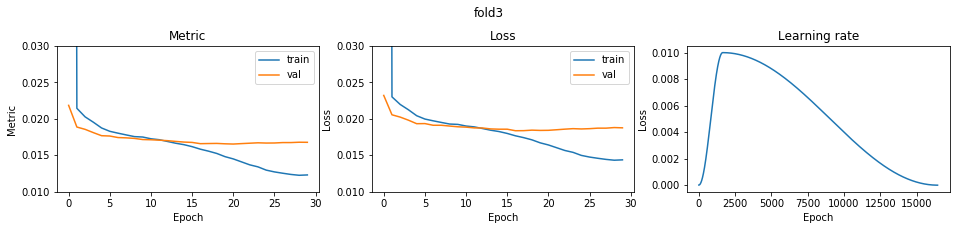

fold 4


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.0214942915301456
epoch2 save best model... 0.019004828729804666
epoch3 save best model... 0.018475297763349663
epoch4 save best model... 0.017963342963036887
epoch5 save best model... 0.017581460424242773
epoch6 save best model... 0.017472554814571127
epoch7 save best model... 0.017382264257767205
epoch8 save best model... 0.017266525712144265
epoch9 save best model... 0.017184808265188697
epoch10 save best model... 0.017043270866104437
epoch11 save best model... 0.01695779225320167
epoch13 save best model... 0.016873863834573767
epoch14 save best model... 0.01678419207182452
epoch15 save best model... 0.016656281108753692
epoch17 save best model... 0.01663919490908436
epoch18 save best model... 0.01651519261818201
epoch19 save best model... 0.016480176376098245
fold4 score: 0.016480176321378263


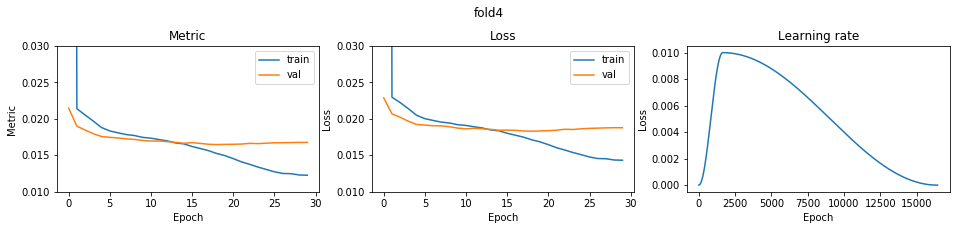

CV score: 0.01642697433804286

optimizer: AdaBound
fold 0


epoch1 save best model... 0.6578182956352321
epoch2 save best model... 0.17849194359263418
epoch3 save best model... 0.039681892475465434
epoch4 save best model... 0.0322993164114094
epoch5 save best model... 0.030544701727756335
epoch6 save best model... 0.03025760373656462
epoch7 save best model... 0.03017177266707317
epoch8 save best model... 0.030093793935038506
fold0 score: 0.030093794009861924


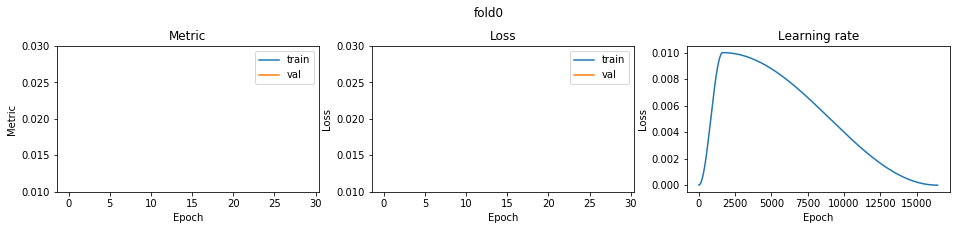

fold 1


epoch1 save best model... 0.6596644284052141
epoch2 save best model... 0.1768261484783096
epoch3 save best model... 0.04015841341848443
epoch4 save best model... 0.0322852853238311
epoch5 save best model... 0.030862812852534924
epoch6 save best model... 0.03033498536365047
epoch7 save best model... 0.030141652821662705
fold1 score: 0.03014165292089973


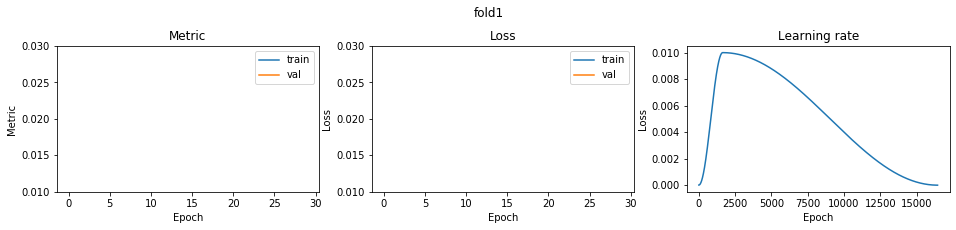

fold 2


epoch1 save best model... 0.6553991848174682
epoch2 save best model... 0.17035728188154772
epoch3 save best model... 0.039463242536716674
epoch4 save best model... 0.032278331581865584
epoch5 save best model... 0.03065430201245457
epoch6 save best model... 0.030454981803476444
epoch7 save best model... 0.030119467553410804
epoch8 save best model... 0.029997314195965383
fold2 score: 0.02999731420839052


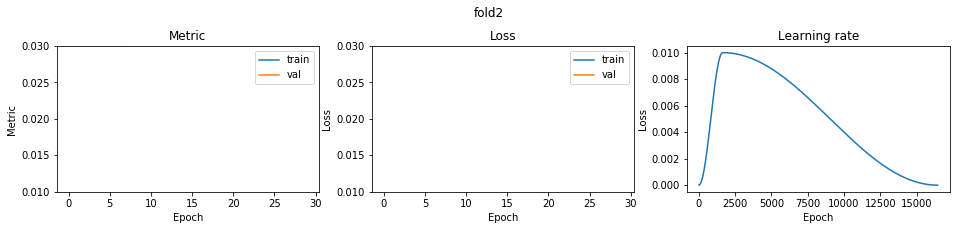

fold 3


epoch1 save best model... 0.6604673322349583
epoch2 save best model... 0.19486239087473015
epoch3 save best model... 0.041085511636082296
epoch4 save best model... 0.03267116255056885
epoch5 save best model... 0.030909692745545458
epoch6 save best model... 0.030460200181277576
epoch7 save best model... 0.030234046377971394
fold3 score: 0.030234046277121503


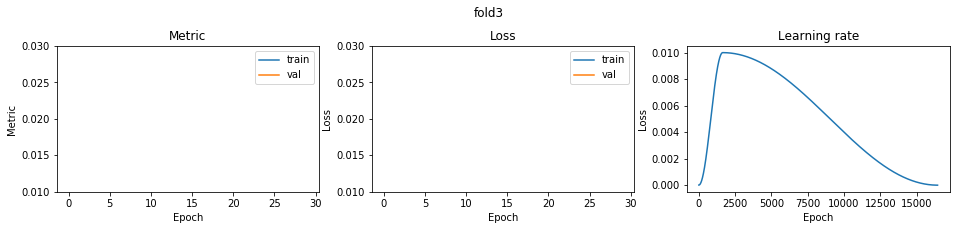

fold 4


epoch1 save best model... 0.6622982518548032
epoch2 save best model... 0.18137388065762836
epoch3 save best model... 0.04037490165145359
epoch4 save best model... 0.03239439078829419
epoch5 save best model... 0.030710542867286875
epoch6 save best model... 0.03035168992291822
epoch7 save best model... 0.030121234752628148
epoch8 save best model... 0.030048340507242022
epoch9 save best model... 0.030030553400143132
fold4 score: 0.030030553337704276


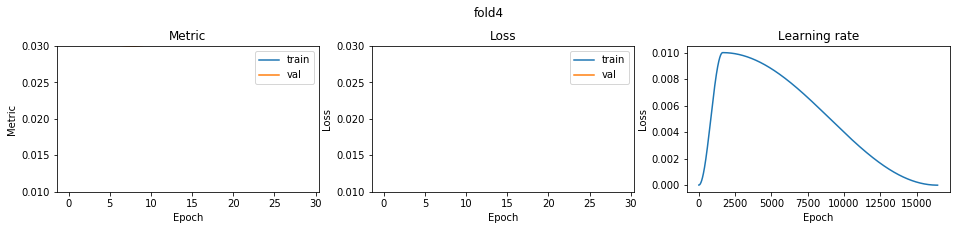

CV score: 0.03009947488348979

optimizer: AdaMod
fold 0


epoch1 save best model... 0.40260115849673067
epoch2 save best model... 0.020070797469729985
epoch3 save best model... 0.018595989449861926
epoch4 save best model... 0.018096562613285485
epoch5 save best model... 0.017710548342292565
epoch6 save best model... 0.017565156650943745
epoch7 save best model... 0.017259038807421176
epoch8 save best model... 0.017104676196135257
epoch9 save best model... 0.01705783243144699
epoch10 save best model... 0.01688113172532214
epoch11 save best model... 0.016786820100353084
epoch13 save best model... 0.01672171271217304
epoch14 save best model... 0.016639847948655046
epoch15 save best model... 0.016539599943337518
epoch16 save best model... 0.016462560142294965
epoch17 save best model... 0.01644785369073883
epoch18 save best model... 0.01633748532843549
epoch20 save best model... 0.016331883626385404
epoch21 save best model... 0.016263568445038824
epoch22 save best model... 0.01625379124753907
epoch23 save best model... 0.016238975888521225
epoch24 

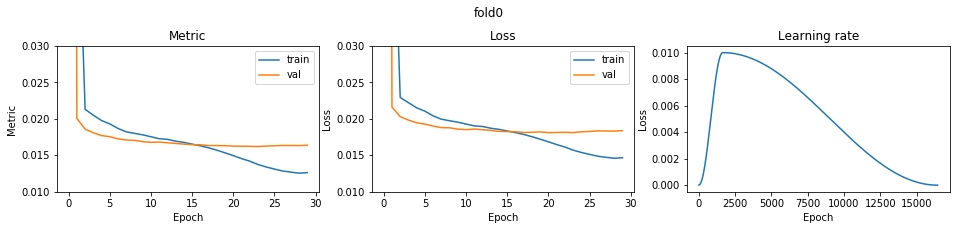

fold 1


epoch1 save best model... 0.43874225559552943
epoch2 save best model... 0.02043167724025619
epoch3 save best model... 0.01902107940084925
epoch4 save best model... 0.0183794560217727
epoch5 save best model... 0.018078836225784635
epoch6 save best model... 0.017888614166876836
epoch7 save best model... 0.017453643903951082
epoch8 save best model... 0.017286454560182095
epoch10 save best model... 0.0171006756481806
epoch12 save best model... 0.016943937095166894
epoch15 save best model... 0.016877100808899464
epoch16 save best model... 0.016839339879529642
epoch17 save best model... 0.016817664723749123
epoch18 save best model... 0.016687516956981615
epoch19 save best model... 0.01660991683313748
epoch22 save best model... 0.016602157306806267
fold1 score: 0.016602157238651508


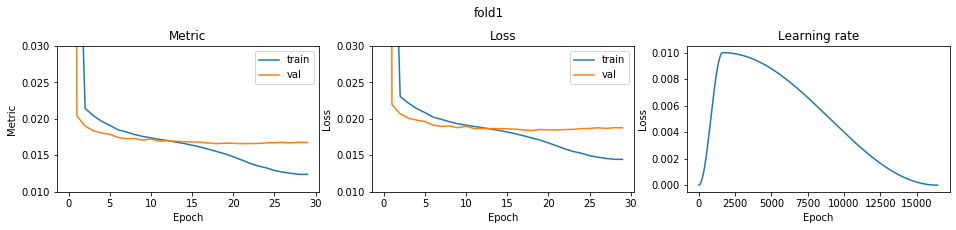

fold 2


epoch1 save best model... 0.40365883477811365
epoch2 save best model... 0.020512318513195942
epoch3 save best model... 0.018673851780294626
epoch4 save best model... 0.018228387352105465
epoch5 save best model... 0.017895959943658564
epoch6 save best model... 0.017563840105287658
epoch7 save best model... 0.01740136312091234
epoch8 save best model... 0.017294353655248534
epoch9 save best model... 0.017053450487246817
epoch10 save best model... 0.016986353504926638
epoch11 save best model... 0.016864057561549437
epoch12 save best model... 0.016796768744603244
epoch13 save best model... 0.016781456397596376
epoch14 save best model... 0.016620323972046158
epoch15 save best model... 0.016567193544207715
epoch17 save best model... 0.016434001847320738
epoch18 save best model... 0.016407098348247596
epoch19 save best model... 0.01636824484423947
epoch21 save best model... 0.016289625349536277
fold2 score: 0.016289625214943114


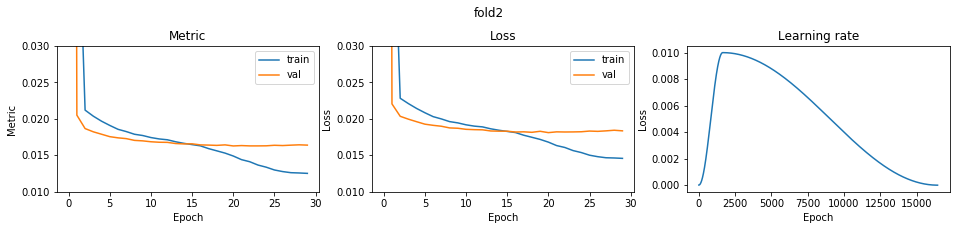

fold 3


epoch1 save best model... 0.3737969024713599
epoch2 save best model... 0.020244771150918783
epoch3 save best model... 0.018831301849242088
epoch4 save best model... 0.018274273632989523
epoch5 save best model... 0.017933442185214955
epoch6 save best model... 0.01761958352831067
epoch8 save best model... 0.017413796668189124
epoch9 save best model... 0.017308526108962122
epoch10 save best model... 0.017029053279557234
epoch12 save best model... 0.016975930698453566
epoch13 save best model... 0.01689814017843752
epoch14 save best model... 0.01680278286490598
epoch16 save best model... 0.01674614945099878
epoch17 save best model... 0.0166083054634019
epoch18 save best model... 0.016598056093842673
epoch19 save best model... 0.016588118211164696
epoch20 save best model... 0.01656523430741186
epoch21 save best model... 0.01650720012410287
epoch22 save best model... 0.01648729342610866
fold3 score: 0.01648729327823738


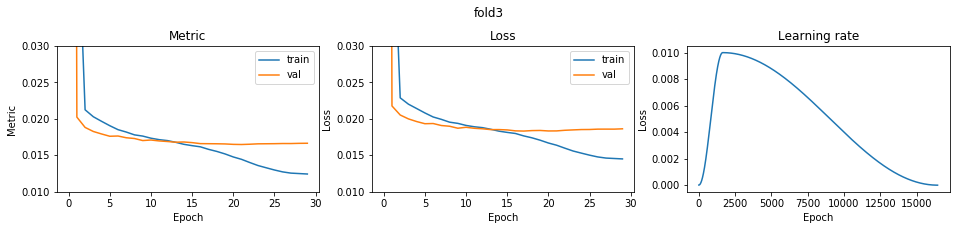

fold 4


epoch1 save best model... 0.4399712970017844
epoch2 save best model... 0.020012096502311137
epoch3 save best model... 0.018819082432462577
epoch4 save best model... 0.018569571201547404
epoch5 save best model... 0.017882025197301067
epoch6 save best model... 0.017489970034595095
epoch7 save best model... 0.017447106398065026
epoch8 save best model... 0.017250621862336144
epoch9 save best model... 0.017066951192372344
epoch12 save best model... 0.016872592732004803
epoch13 save best model... 0.016811712555892783
epoch14 save best model... 0.016756353724179343
epoch15 save best model... 0.016727741490752523
epoch16 save best model... 0.016677872666872717
epoch17 save best model... 0.016672594693822443
epoch18 save best model... 0.016648750333433677
epoch19 save best model... 0.016578224014940593
epoch20 save best model... 0.01644861151109999
fold4 score: 0.01644861150289885


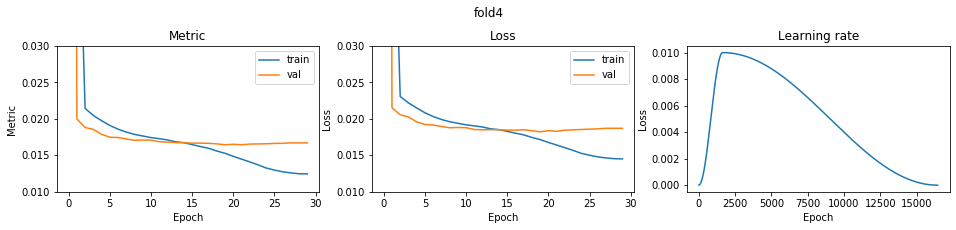

CV score: 0.016408223746881195

optimizer: AdamW
fold 0


epoch1 save best model... 0.02184646751791035
epoch2 save best model... 0.019511383044658596
epoch3 save best model... 0.01830503462234635
epoch4 save best model... 0.017769013396156677
epoch5 save best model... 0.017594640130911166
epoch6 save best model... 0.017311349102976926
epoch7 save best model... 0.017153261041858475
epoch9 save best model... 0.016993321477518267
epoch10 save best model... 0.01690439864534859
epoch11 save best model... 0.016876073655139885
epoch12 save best model... 0.016725064803907702
epoch13 save best model... 0.016720792189545947
epoch14 save best model... 0.016628124363771334
epoch15 save best model... 0.016603256229116053
epoch16 save best model... 0.016486428777320237
epoch17 save best model... 0.016458875855223057
epoch18 save best model... 0.01643474870966005
epoch19 save best model... 0.016347147210380213
epoch20 save best model... 0.01626923742464368
fold0 score: 0.016269237326292183


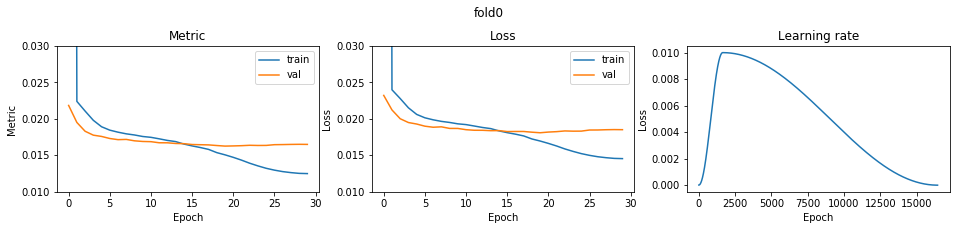

fold 1


epoch1 save best model... 0.02238373810756
epoch2 save best model... 0.019527725226910625
epoch3 save best model... 0.018361887944436585
epoch4 save best model... 0.017958033633010757
epoch5 save best model... 0.017742276660449537
epoch6 save best model... 0.017473671789452735
epoch8 save best model... 0.01726344196852844
epoch10 save best model... 0.017118417765070105
epoch11 save best model... 0.017080884113420614
epoch13 save best model... 0.016992761414836754
epoch14 save best model... 0.016928388016316662
epoch15 save best model... 0.016842590419180466
epoch16 save best model... 0.016671851907994053
epoch18 save best model... 0.016629244382523965
epoch19 save best model... 0.016594705373255886
epoch21 save best model... 0.016543920031574923
fold1 score: 0.01654392001199299


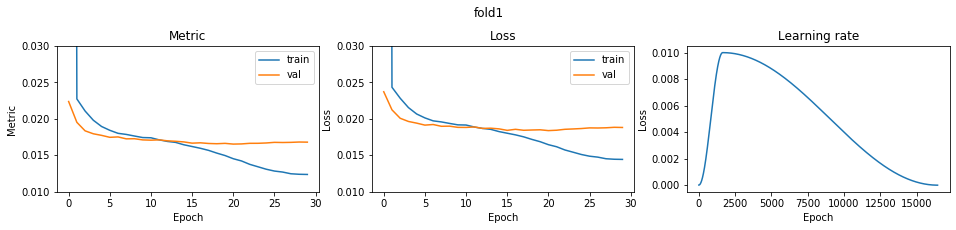

fold 2


epoch1 save best model... 0.022157006084114333
epoch2 save best model... 0.02042901811717678
epoch3 save best model... 0.0186976820767761
epoch4 save best model... 0.017845269531524245
epoch5 save best model... 0.017591590784306773
epoch6 save best model... 0.01743255818772388
epoch7 save best model... 0.017303043233744646
epoch8 save best model... 0.017065456586065123
epoch10 save best model... 0.016992105297552452
epoch11 save best model... 0.016949828441674305
epoch12 save best model... 0.016802366407480753
epoch13 save best model... 0.016785749269271254
epoch14 save best model... 0.016692442942761253
epoch15 save best model... 0.01651544958025414
epoch16 save best model... 0.01650958072362728
epoch17 save best model... 0.01649428667310913
epoch18 save best model... 0.016370713462092713
epoch20 save best model... 0.016351190415811744
epoch21 save best model... 0.01629661134085356
fold2 score: 0.016296611230105475


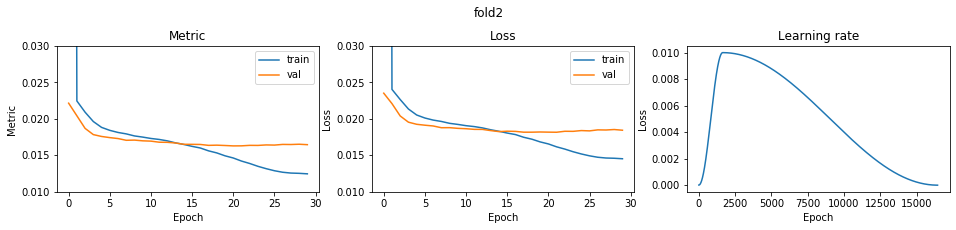

fold 3


epoch1 save best model... 0.022299501378776544
epoch2 save best model... 0.01987298550911604
epoch3 save best model... 0.018652403487448406
epoch4 save best model... 0.018249710141797815
epoch5 save best model... 0.017804501040632876
epoch6 save best model... 0.01742279452350254
epoch8 save best model... 0.017241860681758654
epoch9 save best model... 0.017190584037580225
epoch11 save best model... 0.01701490357390908
epoch13 save best model... 0.016928976987634948
epoch14 save best model... 0.016844435543636526
epoch15 save best model... 0.016819107115421453
epoch16 save best model... 0.016666809071050552
epoch18 save best model... 0.016511531120297712
fold3 score: 0.016511531051902728


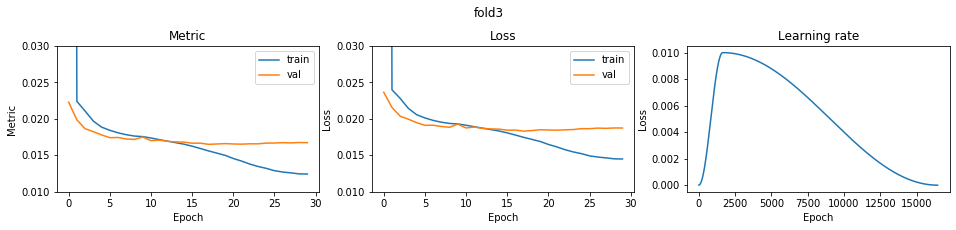

fold 4


epoch1 save best model... 0.022177037887767398
epoch2 save best model... 0.01908900145025487
epoch3 save best model... 0.01848484139533073
epoch4 save best model... 0.017974695879838732
epoch5 save best model... 0.017519887335225092
epoch6 save best model... 0.017480688542127608
epoch7 save best model... 0.017205699762342187
epoch8 save best model... 0.017101484686051386
epoch9 save best model... 0.01708207606700735
epoch10 save best model... 0.017042084123964733
epoch11 save best model... 0.01695351643797545
epoch12 save best model... 0.016879309452900445
epoch13 save best model... 0.016807540638503832
epoch15 save best model... 0.01666083254921409
epoch16 save best model... 0.016603696452356147
epoch17 save best model... 0.0165771616482789
epoch20 save best model... 0.016399100480138713
fold4 score: 0.01639910039320548


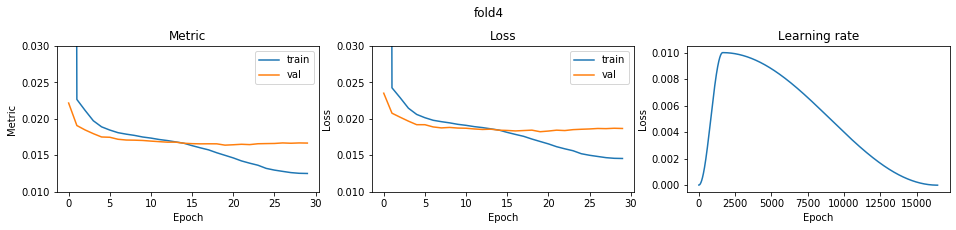

CV score: 0.01640407852779378

optimizer: AdamP
fold 0


epoch1 save best model... 0.021862304340496422
epoch2 save best model... 0.01937890104898559
epoch3 save best model... 0.01874817563369361
epoch4 save best model... 0.017931176383464104
epoch5 save best model... 0.017603255700583065
epoch6 save best model... 0.017385157318212992
epoch7 save best model... 0.01728242960395737
epoch8 save best model... 0.017166345489289875
epoch9 save best model... 0.017013368345712203
epoch11 save best model... 0.016915542986201532
epoch13 save best model... 0.016891275525330682
epoch14 save best model... 0.01669975334188661
epoch16 save best model... 0.01654226953388618
epoch17 save best model... 0.016470239573669596
epoch19 save best model... 0.016326361290414676
epoch20 save best model... 0.016289803051391875
epoch21 save best model... 0.016287975602174404
epoch22 save best model... 0.016195907106449095
fold0 score: 0.016195906827611004


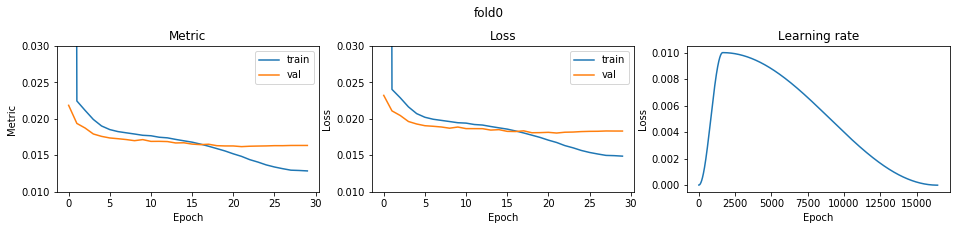

fold 1


epoch1 save best model... 0.021858001790310968
epoch2 save best model... 0.01974226508012025
epoch3 save best model... 0.01858715751049431
epoch4 save best model... 0.01807141927019777
epoch5 save best model... 0.01771518350238272
epoch6 save best model... 0.017638654699754907
epoch7 save best model... 0.017561028314905875
epoch8 save best model... 0.017456204721253848
epoch9 save best model... 0.017298952398805162
epoch10 save best model... 0.01721889059884547
epoch11 save best model... 0.017210597820846524
epoch12 save best model... 0.0169943113526761
epoch13 save best model... 0.016988831165457376
epoch14 save best model... 0.01692815594023739
epoch15 save best model... 0.01686735620765038
epoch16 save best model... 0.016836827909448716
epoch17 save best model... 0.01674798084178922
epoch18 save best model... 0.016621980633426226
epoch20 save best model... 0.0165749634534382
epoch21 save best model... 0.016552923479995728
epoch22 save best model... 0.01648758447842151
fold1 score: 0

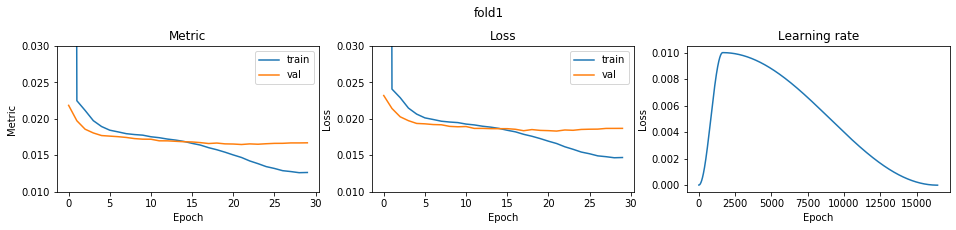

fold 2


epoch1 save best model... 0.02207252831726852
epoch2 save best model... 0.01952324203292142
epoch3 save best model... 0.018515150436414732
epoch4 save best model... 0.0180085836161725
epoch5 save best model... 0.01760971500805867
epoch6 save best model... 0.017399508006128914
epoch8 save best model... 0.01726436401076749
epoch9 save best model... 0.017185442418065435
epoch10 save best model... 0.01703278893678294
epoch11 save best model... 0.016872491667589938
epoch13 save best model... 0.016846954399848426
epoch16 save best model... 0.016642470594124617
epoch17 save best model... 0.016531441762608828
epoch18 save best model... 0.016435191210967908
epoch19 save best model... 0.016402740403033723
epoch20 save best model... 0.016309511799413662
epoch21 save best model... 0.016301208056889747
epoch22 save best model... 0.01627972169031679
fold2 score: 0.016279721682172173


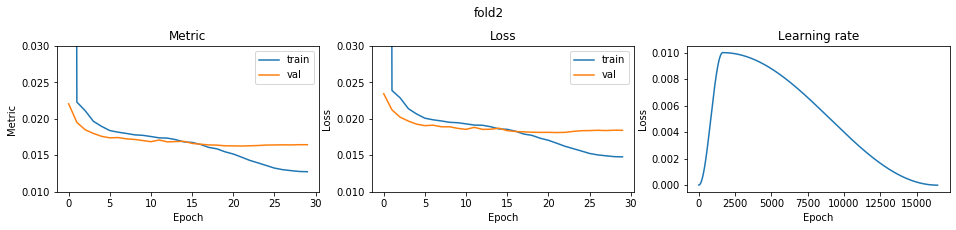

fold 3


epoch1 save best model... 0.022408978219286186
epoch2 save best model... 0.019627697274920475
epoch3 save best model... 0.01868259570389511
epoch4 save best model... 0.018197950684722165
epoch5 save best model... 0.01782978468644592
epoch6 save best model... 0.0176340914685661
epoch7 save best model... 0.017363485104588957
epoch10 save best model... 0.017305595898292194
epoch11 save best model... 0.0170626285649276
epoch12 save best model... 0.01702848420200492
epoch13 save best model... 0.016985668334897803
epoch14 save best model... 0.01695836875927136
epoch15 save best model... 0.016844720784192885
epoch16 save best model... 0.01678486939663903
epoch17 save best model... 0.016648664088296048
epoch18 save best model... 0.01655379460152909
epoch19 save best model... 0.01652460848034311
epoch21 save best model... 0.016440848596733497
epoch22 save best model... 0.01639731465828242
fold3 score: 0.016397314580108985


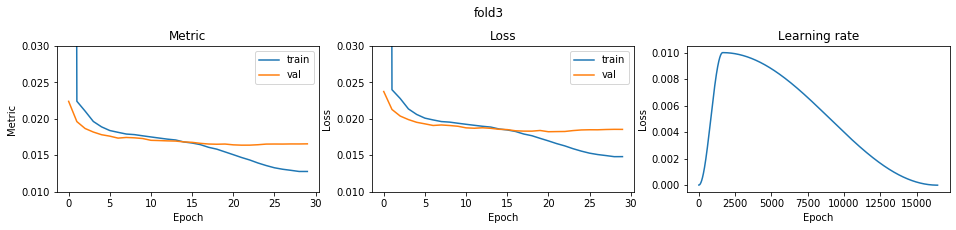

fold 4


epoch1 save best model... 0.022440829524316384
epoch2 save best model... 0.01942461003339372
epoch3 save best model... 0.01836790827088109
epoch4 save best model... 0.017816630375395468
epoch5 save best model... 0.01764452399257443
epoch6 save best model... 0.017318122136429935
epoch8 save best model... 0.017223067231612082
epoch10 save best model... 0.01714223432683456
epoch11 save best model... 0.017134404457375782
epoch13 save best model... 0.016876070743218778
epoch16 save best model... 0.01671354569163776
epoch17 save best model... 0.016642018133914416
epoch18 save best model... 0.016599252633326147
epoch20 save best model... 0.016567857003429214
epoch21 save best model... 0.016545644409716943
epoch23 save best model... 0.016529906302656563
fold4 score: 0.016529906139068927


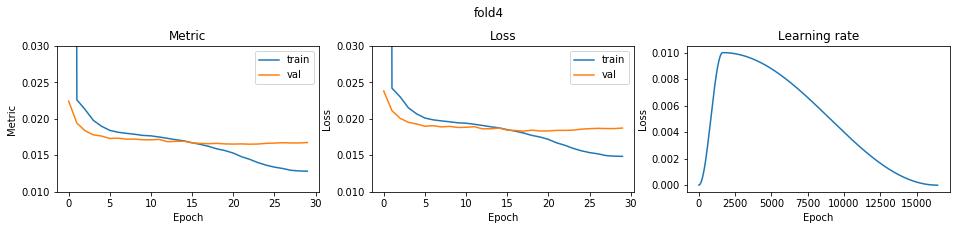

CV score: 0.016378086179845344

optimizer: DiffGrad
fold 0


epoch1 save best model... 0.04509744056265012
epoch2 save best model... 0.03165748274645393
fold0 score: 0.03165748275992011


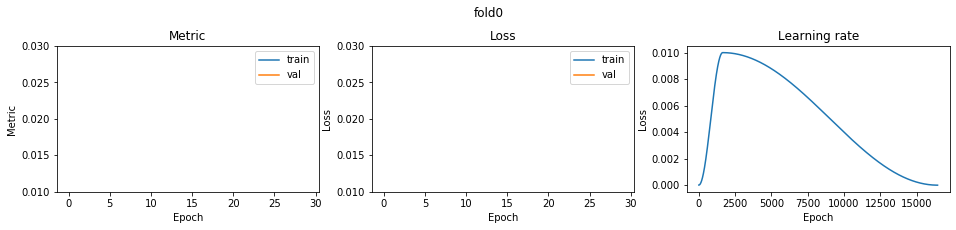

fold 1


epoch1 save best model... 0.04169680733945816
epoch2 save best model... 0.03109685408227752
fold1 score: 0.031096853977424982


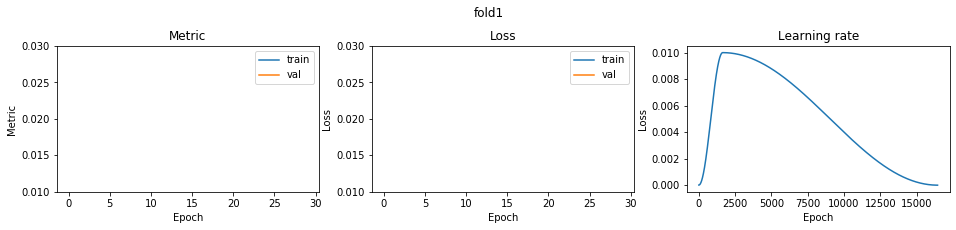

fold 2


epoch1 save best model... 0.041993412269183024
epoch2 save best model... 0.03112232669386703
fold2 score: 0.031122326694424066


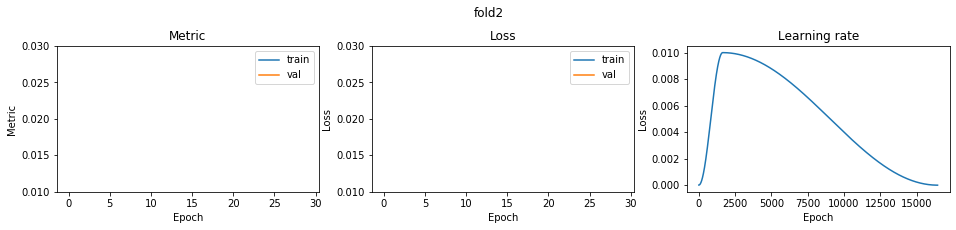

fold 3


epoch1 save best model... 0.041845713423433496
epoch2 save best model... 0.03168776622445138
fold3 score: 0.03168776627008271


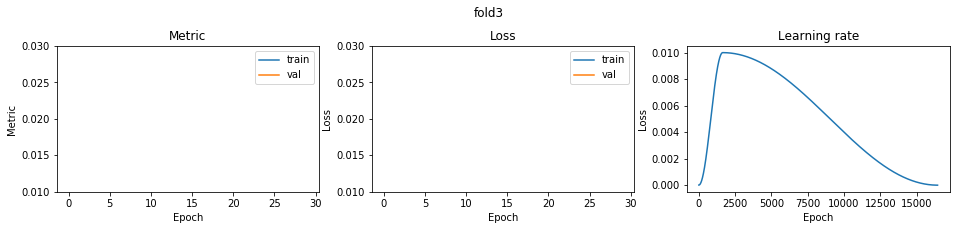

fold 4


epoch1 save best model... 0.04192469235772695
epoch2 save best model... 0.03126080024537709
fold4 score: 0.031260800211561045


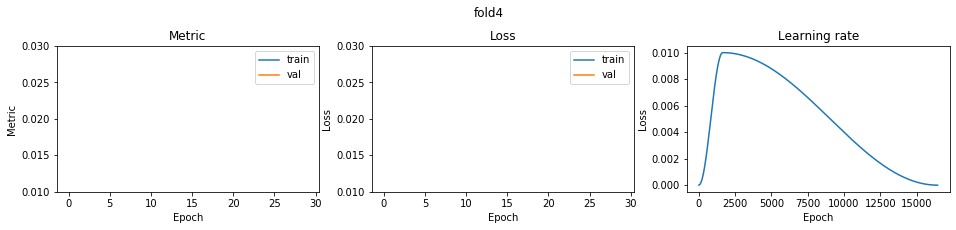

CV score: 0.03136506926094454

optimizer: Lamb
fold 0


epoch1 save best model... 0.6862768777139094
epoch2 save best model... 0.512016180897628
epoch3 save best model... 0.03320292243246065
epoch4 save best model... 0.018422816131170628
epoch5 save best model... 0.01778420684668225
epoch6 save best model... 0.017468633630858196
epoch7 save best model... 0.017241117749405614
epoch8 save best model... 0.016966838938669897
epoch9 save best model... 0.016965306198101382
epoch10 save best model... 0.016816317234909617
epoch11 save best model... 0.016594156868552156
epoch12 save best model... 0.016505021360068494
epoch13 save best model... 0.01644357749874065
epoch14 save best model... 0.016405550844899478
epoch15 save best model... 0.01633699186748755
epoch16 save best model... 0.016304231342564684
epoch17 save best model... 0.016244525912563593
fold0 score: 0.016244525834570474


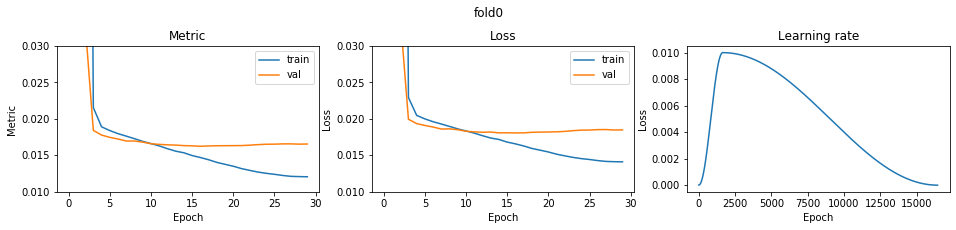

fold 1


epoch1 save best model... 0.6843566241175255
epoch2 save best model... 0.4968556040890751
epoch3 save best model... 0.031696491902127547
epoch4 save best model... 0.018474212462092268
epoch5 save best model... 0.01792293067110796
epoch6 save best model... 0.01768131376816841
epoch7 save best model... 0.01746238814316746
epoch8 save best model... 0.01724638481955236
epoch9 save best model... 0.017038836327883698
epoch10 save best model... 0.01687608328625631
epoch12 save best model... 0.01675923794336527
epoch13 save best model... 0.01675388417963179
epoch14 save best model... 0.016752583965893405
epoch15 save best model... 0.01665247551393206
epoch16 save best model... 0.016608539602693147
fold1 score: 0.016608539501087417


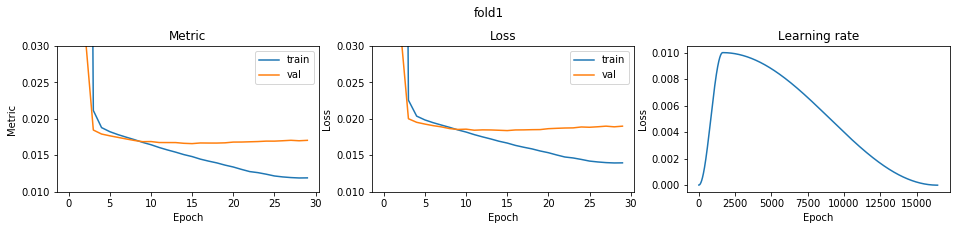

fold 2


epoch1 save best model... 0.6869761768085969
epoch2 save best model... 0.5180357637044698
epoch3 save best model... 0.033399262330368565
epoch4 save best model... 0.018420705377824705
epoch5 save best model... 0.017920560948932653
epoch6 save best model... 0.017598023569165955
epoch7 save best model... 0.017306950538510217
epoch8 save best model... 0.01697444027906386
epoch9 save best model... 0.016918043319732595
epoch10 save best model... 0.01672113508726204
epoch11 save best model... 0.016633969002952265
epoch12 save best model... 0.016555268434168102
epoch13 save best model... 0.01651762086769923
epoch14 save best model... 0.016431490353192548
epoch18 save best model... 0.016386172495906296
fold2 score: 0.01638617233328067


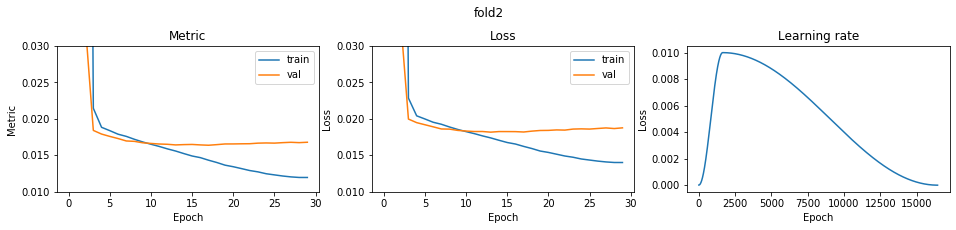

fold 3


epoch1 save best model... 0.6804125096097351
epoch2 save best model... 0.4822986006465208
epoch3 save best model... 0.03132301365409326
epoch4 save best model... 0.018591191892879156
epoch5 save best model... 0.018014805337545677
epoch6 save best model... 0.017666568444587784
epoch7 save best model... 0.01741843564660715
epoch8 save best model... 0.017297437030542005
epoch9 save best model... 0.017129902556487667
epoch10 save best model... 0.01702269252754561
epoch11 save best model... 0.01688596358807049
epoch12 save best model... 0.016748720669274585
epoch13 save best model... 0.016726548830153322
epoch14 save best model... 0.01658207685188104
fold3 score: 0.0165820768624123


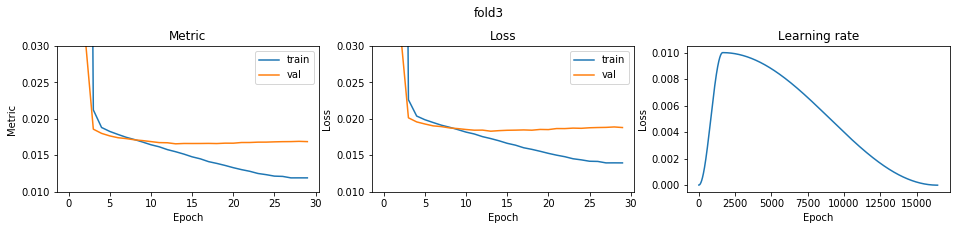

fold 4


epoch1 save best model... 0.6854155471221732
epoch2 save best model... 0.4975113408983704
epoch3 save best model... 0.032284420410463914
epoch4 save best model... 0.01846003813927904
epoch5 save best model... 0.017866656106126606
epoch6 save best model... 0.01755683130854083
epoch7 save best model... 0.017293933753543673
epoch8 save best model... 0.01717790968690687
epoch9 save best model... 0.01698076693396294
epoch10 save best model... 0.01693451703825206
epoch11 save best model... 0.016766235271812435
epoch12 save best model... 0.016724442128423
epoch13 save best model... 0.01664074217234494
epoch15 save best model... 0.016543882338495623
fold4 score: 0.016543882242683012


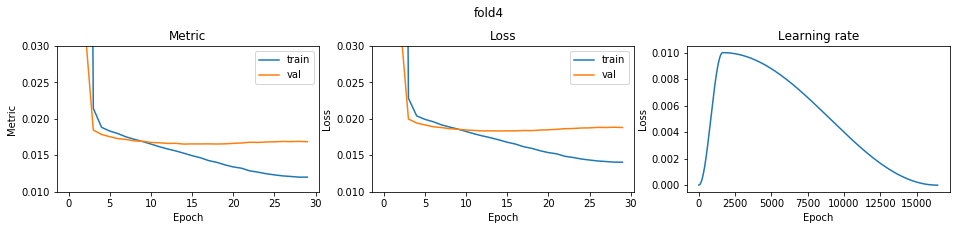

CV score: 0.01647303713897277

optimizer: NovoGrad
fold 0


epoch1 save best model... 0.05445786646666994
epoch2 save best model... 0.01907283232922842
epoch3 save best model... 0.01807347819769165
epoch4 save best model... 0.017633649130650967
epoch5 save best model... 0.017275883695259182
epoch6 save best model... 0.017048853096087592
epoch7 save best model... 0.016794526365698063
epoch8 save best model... 0.016738348981208573
epoch9 save best model... 0.016629153575773662
epoch10 save best model... 0.01651293670160352
epoch11 save best model... 0.016456660381380408
epoch12 save best model... 0.0163356194412654
epoch13 save best model... 0.016242361824815258
epoch15 save best model... 0.016242123328590582
epoch16 save best model... 0.016188828617011902
epoch17 save best model... 0.016182653718375534
epoch18 save best model... 0.016127212079144283
epoch21 save best model... 0.016092816679176274
epoch24 save best model... 0.016045165754820737
epoch27 save best model... 0.01604263292527959
epoch28 save best model... 0.016028498646491345
epoch30 

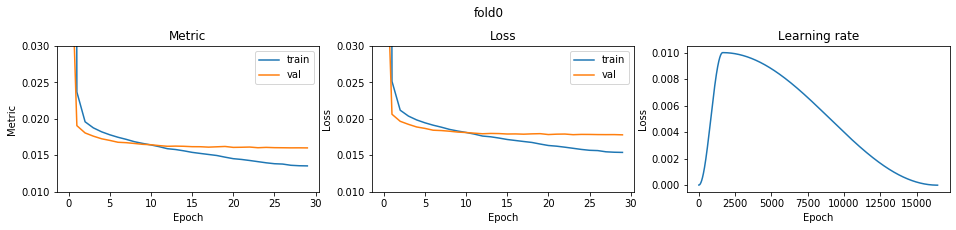

fold 1


epoch1 save best model... 0.053595652228730986
epoch2 save best model... 0.019237398854687074
epoch3 save best model... 0.01812838869138374
epoch4 save best model... 0.01777159020484621
epoch5 save best model... 0.01750632698778602
epoch6 save best model... 0.017291430120374842
epoch7 save best model... 0.01722373621439399
epoch8 save best model... 0.017075764412545456
epoch9 save best model... 0.016845849281532137
epoch10 save best model... 0.016814490761773396
epoch12 save best model... 0.016717255327703743
epoch13 save best model... 0.016599494510212066
epoch16 save best model... 0.01655663617505289
epoch17 save best model... 0.016491986005033345
epoch19 save best model... 0.01648762446142161
epoch21 save best model... 0.01646853746380763
epoch22 save best model... 0.01645310139073465
epoch23 save best model... 0.016445210881702692
epoch26 save best model... 0.01643530160399172
fold1 score: 0.016435301602381158


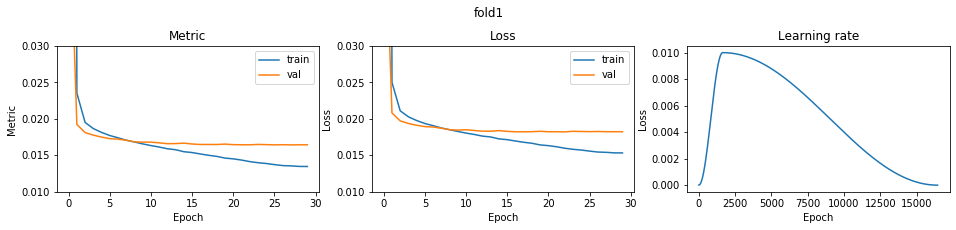

fold 2


epoch1 save best model... 0.054409950942744915
epoch2 save best model... 0.019093898132844053
epoch3 save best model... 0.018135088809746142
epoch4 save best model... 0.01765728770381981
epoch5 save best model... 0.01731961272448118
epoch6 save best model... 0.01712836096698567
epoch7 save best model... 0.016918062276359055
epoch8 save best model... 0.01686861601866753
epoch9 save best model... 0.016725105352743894
epoch10 save best model... 0.01663151482855623
epoch11 save best model... 0.016568008565196867
epoch13 save best model... 0.016427646090201635
epoch15 save best model... 0.016390265378524716
epoch17 save best model... 0.016359027433104086
epoch18 save best model... 0.016309195782290717
epoch20 save best model... 0.016279253082918155
epoch21 save best model... 0.016254801604040366
epoch22 save best model... 0.01623235900047551
epoch27 save best model... 0.01623098335215492
epoch30 save best model... 0.01622130320844359
fold2 score: 0.016221303235501038


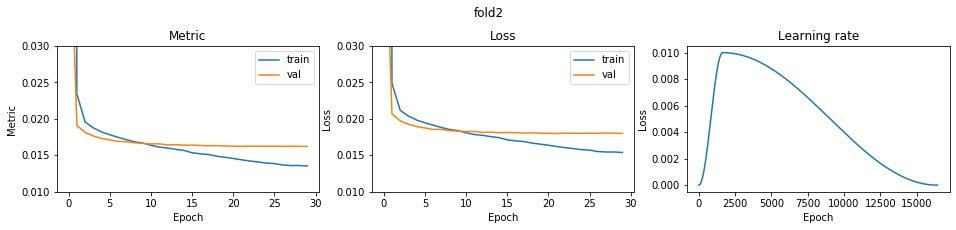

fold 3


epoch1 save best model... 0.05287581414900771
epoch2 save best model... 0.019379676107936675
epoch3 save best model... 0.018299567553051375
epoch4 save best model... 0.01787146059902287
epoch5 save best model... 0.017566075506524642
epoch6 save best model... 0.017369151372114592
epoch7 save best model... 0.01726188294139769
epoch8 save best model... 0.017111283512298094
epoch9 save best model... 0.01698936617133422
epoch10 save best model... 0.016908512177934407
epoch11 save best model... 0.016787418335727108
epoch12 save best model... 0.01674051673399764
epoch13 save best model... 0.016642786706702314
epoch14 save best model... 0.016632694361099213
epoch15 save best model... 0.016618496956885
epoch16 save best model... 0.01651622657632298
epoch17 save best model... 0.016498300407277018
epoch19 save best model... 0.016489061363177175
epoch20 save best model... 0.016457087383234283
epoch23 save best model... 0.016420222987719984
epoch28 save best model... 0.016402313266382265
fold3 scor

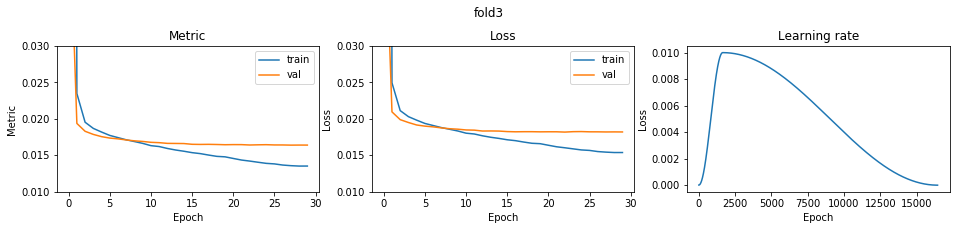

fold 4


epoch1 save best model... 0.053643107617906124
epoch2 save best model... 0.019009360116068488
epoch3 save best model... 0.0181144967267888
epoch4 save best model... 0.0176363004303637
epoch5 save best model... 0.017374891573499574
epoch6 save best model... 0.017185728896859022
epoch7 save best model... 0.016996053387336688
epoch8 save best model... 0.016856769092194312
epoch9 save best model... 0.01679885333111183
epoch10 save best model... 0.01669111018427616
epoch11 save best model... 0.016559604176475003
epoch13 save best model... 0.016548394430471174
epoch14 save best model... 0.01651887832027022
epoch15 save best model... 0.016467040581607466
epoch16 save best model... 0.01646545818521045
epoch17 save best model... 0.01642669867681751
epoch18 save best model... 0.016413595746769857
epoch20 save best model... 0.016369918772870154
epoch21 save best model... 0.016365040482736803
epoch22 save best model... 0.01631912399838617
epoch24 save best model... 0.016315572842921646
epoch30 sav

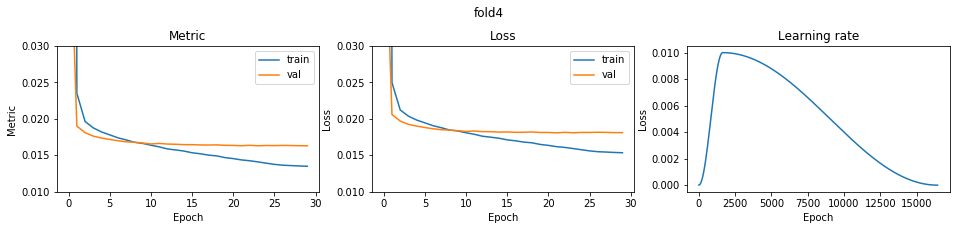

CV score: 0.016278521554472028

optimizer: PlainRAdam
fold 0


epoch1 save best model... 0.04018990669170382
epoch2 save best model... 0.02022375889835298
epoch3 save best model... 0.018887863420204584
epoch4 save best model... 0.018155811083819164
epoch5 save best model... 0.017655466608957712
epoch6 save best model... 0.017296412605834713
epoch8 save best model... 0.01709871589882906
epoch9 save best model... 0.017034158290518714
epoch10 save best model... 0.016895830139076518
epoch12 save best model... 0.016837934292598302
epoch13 save best model... 0.01672085525981386
epoch14 save best model... 0.016671627438743866
epoch15 save best model... 0.01654390451033729
epoch16 save best model... 0.016422049062653255
epoch19 save best model... 0.016323989662840318
epoch21 save best model... 0.01624171898439357
fold0 score: 0.01624171889534125


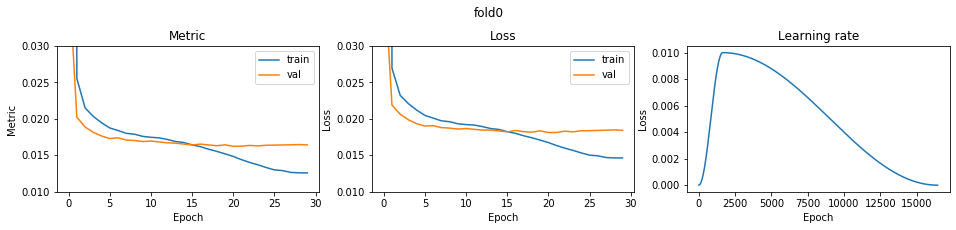

fold 1


epoch1 save best model... 0.03618171761535137
epoch2 save best model... 0.019992229432600945
epoch3 save best model... 0.018695288660090886
epoch4 save best model... 0.0184178538739301
epoch5 save best model... 0.017771399688798113
epoch6 save best model... 0.017566375520125313
epoch7 save best model... 0.017459694084351277
epoch8 save best model... 0.017364526944144573
epoch9 save best model... 0.017243966301506323
epoch11 save best model... 0.017111789617635688
epoch12 save best model... 0.017088223701331482
epoch13 save best model... 0.016989925525714145
epoch14 save best model... 0.016926634469803522
epoch15 save best model... 0.016833935136654078
epoch16 save best model... 0.01683036021643808
epoch17 save best model... 0.01668527439248524
epoch18 save best model... 0.016616120121568462
epoch19 save best model... 0.016603730401878517
epoch20 save best model... 0.016569241716707452
epoch22 save best model... 0.016525802048045008
epoch23 save best model... 0.016494860272539668
fold1 

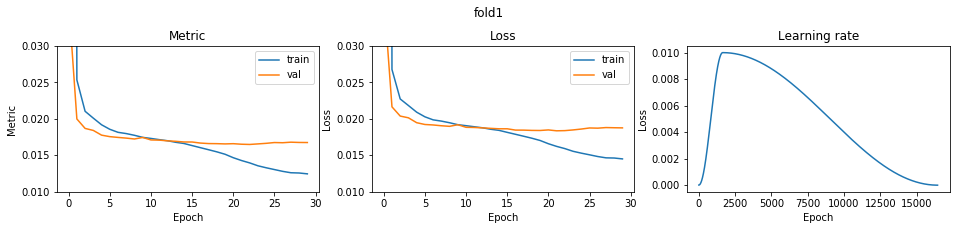

fold 2


epoch1 save best model... 0.04002161725751222
epoch2 save best model... 0.01989314178720806
epoch3 save best model... 0.01870824048228988
epoch4 save best model... 0.018066739500516175
epoch5 save best model... 0.018015693379602148
epoch6 save best model... 0.017559255612091054
epoch7 save best model... 0.01713027269637824
epoch10 save best model... 0.016997452810029828
epoch12 save best model... 0.016855639832908716
epoch13 save best model... 0.01676955934012159
epoch15 save best model... 0.01669887150133843
epoch16 save best model... 0.016609449424638947
epoch17 save best model... 0.01649620273191033
epoch18 save best model... 0.01645402116694641
epoch20 save best model... 0.016324769742243665
fold2 score: 0.016324769701428977


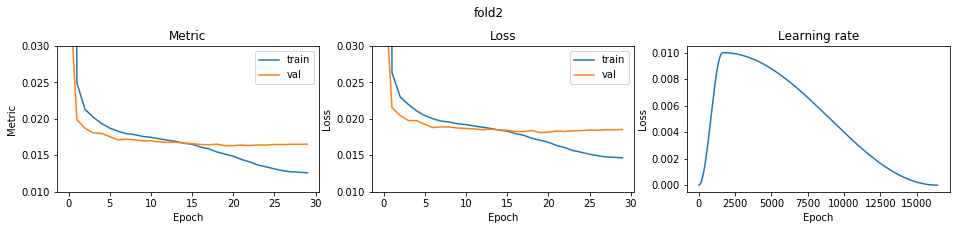

fold 3


epoch1 save best model... 0.03689023997456446
epoch2 save best model... 0.02040383343994278
epoch3 save best model... 0.018879991545339786
epoch4 save best model... 0.018371033760589593
epoch5 save best model... 0.017877932399053102
epoch6 save best model... 0.017686638005230584
epoch7 save best model... 0.01746453950202818
epoch9 save best model... 0.01720679747513527
epoch10 save best model... 0.017086428543446684
epoch13 save best model... 0.016899451329998656
epoch15 save best model... 0.01682720018639855
epoch16 save best model... 0.016666339920379712
epoch18 save best model... 0.016640916658917565
epoch19 save best model... 0.01655217402345227
epoch20 save best model... 0.016503459615696537
epoch23 save best model... 0.016455360810889743
fold3 score: 0.016455360846541468


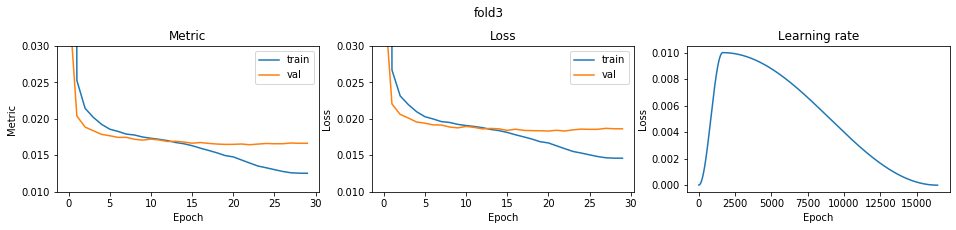

fold 4


epoch1 save best model... 0.037554969535058616
epoch2 save best model... 0.019554609080653526
epoch3 save best model... 0.018917727795830484
epoch4 save best model... 0.01794561662993358
epoch5 save best model... 0.0177494476657522
epoch6 save best model... 0.01751610573703648
epoch7 save best model... 0.01742209850859262
epoch8 save best model... 0.017294658315293747
epoch9 save best model... 0.017166115994860072
epoch10 save best model... 0.01715781500940646
epoch11 save best model... 0.016992014362678304
epoch12 save best model... 0.016889347360471523
epoch14 save best model... 0.01680484167671421
epoch15 save best model... 0.016803788957196652
epoch17 save best model... 0.016673441211309006
epoch18 save best model... 0.01656457099019802
epoch20 save best model... 0.016509025834144382
epoch21 save best model... 0.01650310934421549
fold4 score: 0.016503109254971


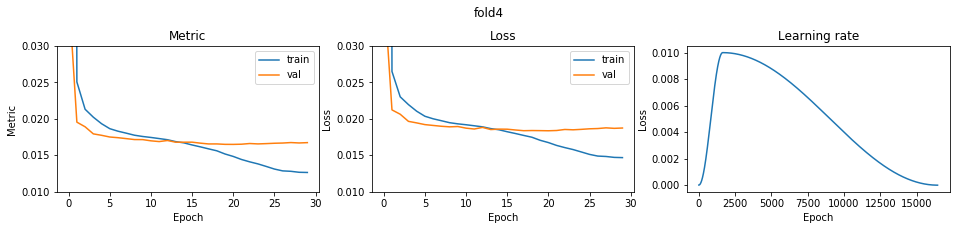

CV score: 0.01640396323826289

optimizer: QHAdam
fold 0


epoch1 save best model... 0.03390301136058121
epoch2 save best model... 0.03194303639097339
fold0 score: 0.031943036178338456


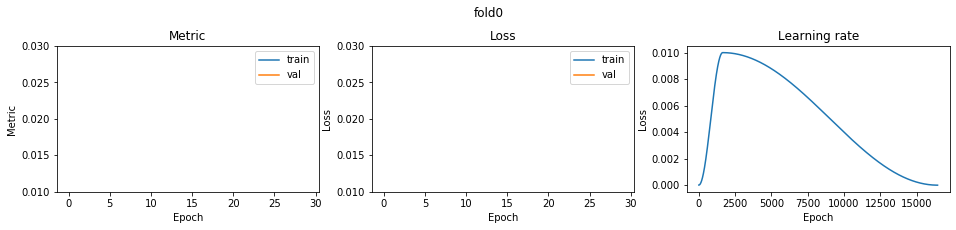

fold 1


epoch1 save best model... 0.0349562420743382
epoch2 save best model... 0.031738325048685345
epoch17 save best model... 0.0316210977638072
fold1 score: 0.031621096238687765


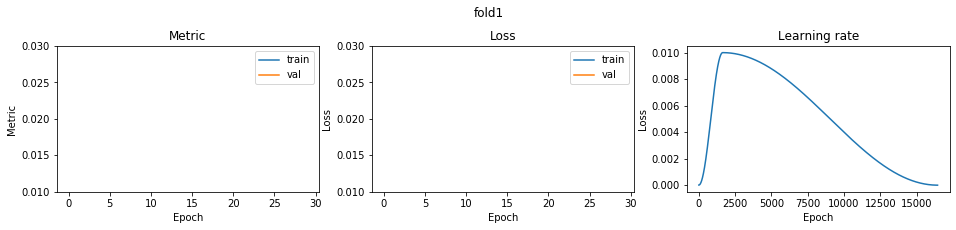

fold 2


epoch1 save best model... 0.03588903293957415
epoch2 save best model... 0.03175948324192491
epoch12 save best model... 0.03136859138237979
fold2 score: 0.03136859203984795


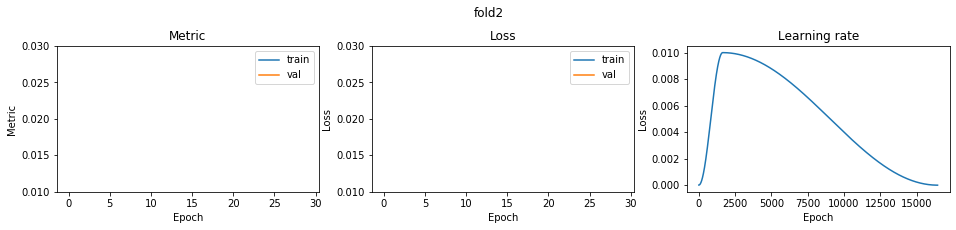

fold 3


epoch1 save best model... 0.034203953404565064
epoch2 save best model... 0.031990726863231365
fold3 score: 0.03199072687065699


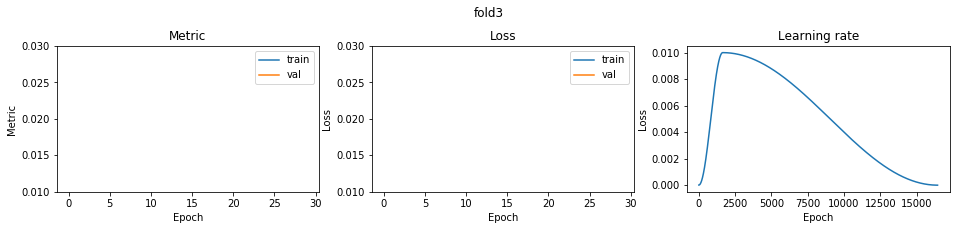

fold 4


epoch1 save best model... 0.033846389356330206
epoch2 save best model... 0.031644590902471056
fold4 score: 0.03164459077743


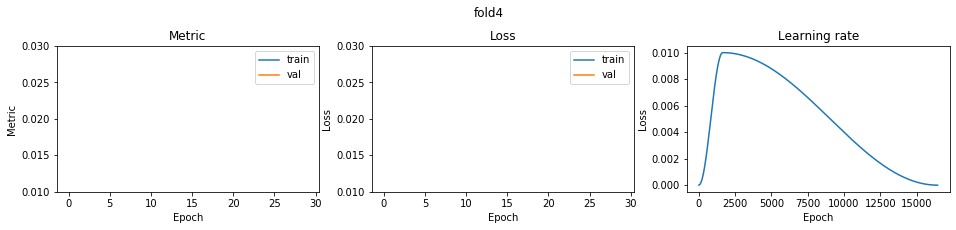

CV score: 0.03171362835577278

optimizer: RAdam
fold 0


epoch1 save best model... 0.03874897850774958
epoch2 save best model... 0.020551192379452646
epoch3 save best model... 0.018519080931783265
epoch4 save best model... 0.018270482956209054
epoch5 save best model... 0.01769493591795614
epoch6 save best model... 0.017451624153924424
epoch7 save best model... 0.01723449803753024
epoch8 save best model... 0.0171834756198057
epoch9 save best model... 0.017040226046751192
epoch10 save best model... 0.016805027765571936
epoch12 save best model... 0.016701636285200747
epoch13 save best model... 0.016641595313889833
epoch15 save best model... 0.016581612361217413
epoch16 save best model... 0.016451070857804975
epoch17 save best model... 0.01640111594747302
epoch19 save best model... 0.016354115445226226
epoch20 save best model... 0.01624657335884207
fold0 score: 0.016246573319893907


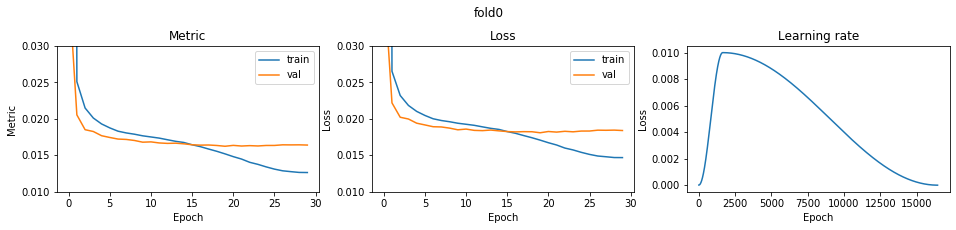

fold 1


epoch1 save best model... 0.03578369090947672
epoch2 save best model... 0.01994147789438579
epoch3 save best model... 0.018806060949689736
epoch4 save best model... 0.018247480069003418
epoch5 save best model... 0.01778305270410964
epoch6 save best model... 0.01773598302884834
epoch7 save best model... 0.017516073833842922
epoch8 save best model... 0.01734608543774049
epoch9 save best model... 0.017268531156016745
epoch10 save best model... 0.017074272133313216
epoch11 save best model... 0.01704681035845039
epoch12 save best model... 0.016994240627543247
epoch13 save best model... 0.016970420208301053
epoch14 save best model... 0.016833247731472236
epoch15 save best model... 0.016775885061928515
epoch16 save best model... 0.01672527526574679
epoch17 save best model... 0.01672224693406033
epoch18 save best model... 0.01658428194564482
epoch21 save best model... 0.016572042464901005
epoch22 save best model... 0.01653447577517202
fold1 score: 0.01653447558682017


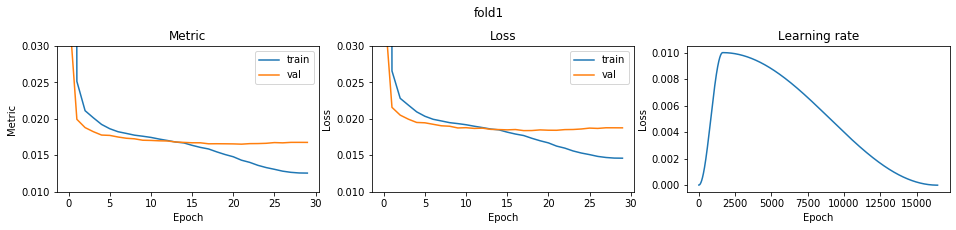

fold 2


epoch1 save best model... 0.03768144136621078
epoch2 save best model... 0.01974094956629462
epoch3 save best model... 0.018775226590328646
epoch4 save best model... 0.01814622301769592
epoch5 save best model... 0.01773022767899044
epoch6 save best model... 0.017534538796674447
epoch7 save best model... 0.017426833047177816
epoch8 save best model... 0.017370788900168493
epoch10 save best model... 0.01703716010597103
epoch11 save best model... 0.01692611935653945
epoch13 save best model... 0.016834192351228246
epoch15 save best model... 0.016695638829967406
epoch16 save best model... 0.01655918835518225
epoch17 save best model... 0.016533275557341135
epoch18 save best model... 0.016398898228675324
epoch20 save best model... 0.01635776717478049
epoch21 save best model... 0.01633728701259714
epoch22 save best model... 0.016332400938095796
fold2 score: 0.016332400785937222


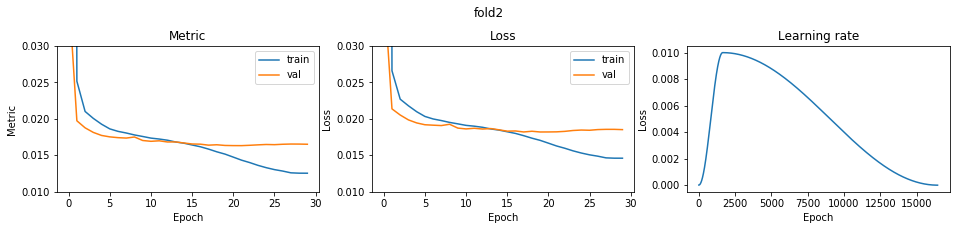

fold 3


epoch1 save best model... 0.03950246603722453
epoch2 save best model... 0.019885399693661373
epoch3 save best model... 0.01872711679887595
epoch4 save best model... 0.01829113361843626
epoch5 save best model... 0.017947992912847932
epoch6 save best model... 0.01781113595746305
epoch7 save best model... 0.01761434796756316
epoch8 save best model... 0.017458285965398803
epoch9 save best model... 0.017268259078264236
epoch10 save best model... 0.017146616620022235
epoch12 save best model... 0.01701483931986441
epoch15 save best model... 0.016835482388412357
epoch16 save best model... 0.016717127444549274
epoch17 save best model... 0.01665415894070424
epoch18 save best model... 0.016615855483367938
epoch19 save best model... 0.016545014517861237
epoch20 save best model... 0.016459160080022583
fold3 score: 0.01645916001093482


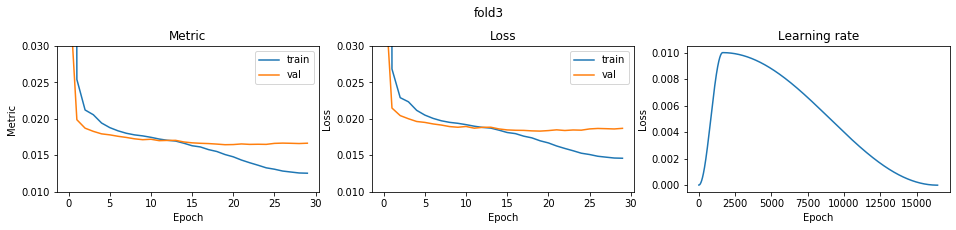

fold 4


epoch1 save best model... 0.03609824463097137
epoch2 save best model... 0.020325230997149113
epoch3 save best model... 0.018562876550238878
epoch4 save best model... 0.018115744394820887
epoch5 save best model... 0.017783521148026126
epoch6 save best model... 0.017436544615393484
epoch7 save best model... 0.01728556204485391
epoch8 save best model... 0.017183206526134035
epoch10 save best model... 0.01695160276016776
epoch11 save best model... 0.016909596252261506
epoch14 save best model... 0.01682713848786908
epoch15 save best model... 0.016715286217697797
epoch16 save best model... 0.016650879532013912
epoch17 save best model... 0.016574795496626705
epoch18 save best model... 0.01652053688994369
epoch20 save best model... 0.016473347952924582
fold4 score: 0.016473347931461123


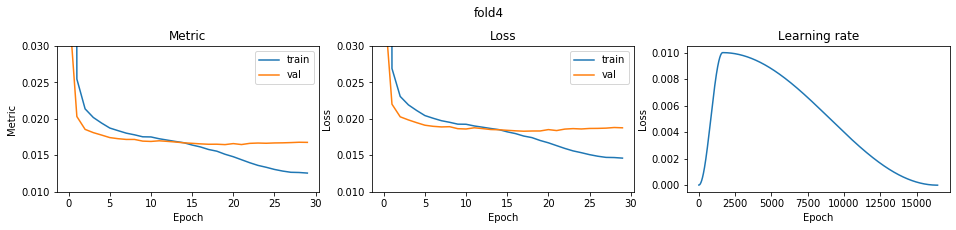

CV score: 0.016409189317545318

optimizer: Ranger
fold 0


epoch1 save best model... 0.24316666082124774
epoch2 save best model... 0.02035078760109214
epoch3 save best model... 0.018872804378831848
epoch4 save best model... 0.01797821611115085
epoch5 save best model... 0.017660979459015548
epoch6 save best model... 0.01739656509818819
epoch7 save best model... 0.017170842179438792
epoch8 save best model... 0.017082271926054108
epoch9 save best model... 0.01681535379676857
epoch10 save best model... 0.016755688333022566
epoch11 save best model... 0.01671697257345453
epoch12 save best model... 0.016573952396818203
epoch13 save best model... 0.016528912727850446
epoch14 save best model... 0.016484043064923928
epoch15 save best model... 0.01646128694287126
epoch16 save best model... 0.016351680022691946
epoch17 save best model... 0.01624799472808091
epoch21 save best model... 0.016232248767786117
fold0 score: 0.016232248652887093


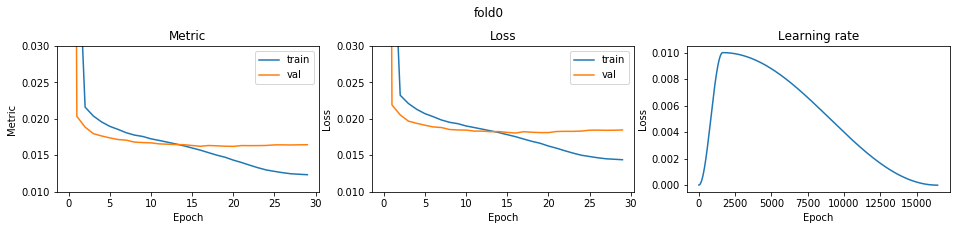

fold 1


epoch1 save best model... 0.24532647311049188
epoch2 save best model... 0.020799861583450464
epoch3 save best model... 0.019168030945925812
epoch4 save best model... 0.018468503853211537
epoch6 save best model... 0.01770503632681846
epoch8 save best model... 0.017369591745792612
epoch9 save best model... 0.01718644121664753
epoch10 save best model... 0.017059010074966845
epoch11 save best model... 0.016877608497682887
epoch14 save best model... 0.016744903940007203
epoch15 save best model... 0.016716088083657352
epoch17 save best model... 0.016677221272282487
epoch18 save best model... 0.01659171742094924
epoch19 save best model... 0.016567472544175992
epoch20 save best model... 0.01654413432425228
fold1 score: 0.016544134211073164


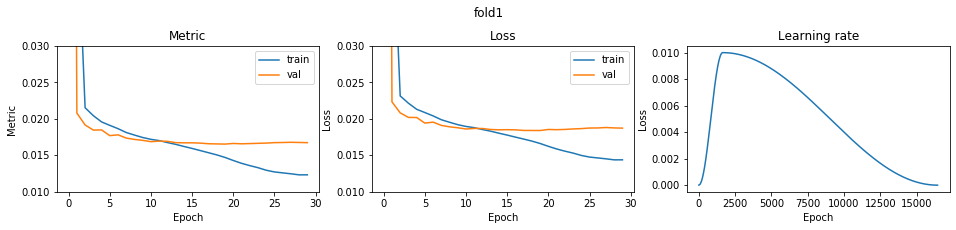

fold 2


epoch1 save best model... 0.24098998919981546
epoch2 save best model... 0.02158899167601395
epoch3 save best model... 0.01955985302845257
epoch4 save best model... 0.01824456683490964
epoch5 save best model... 0.017889130584926166
epoch6 save best model... 0.017514732688169703
epoch7 save best model... 0.0172785671481319
epoch8 save best model... 0.0171722979442908
epoch9 save best model... 0.01707656000286517
epoch10 save best model... 0.01689248972657901
epoch11 save best model... 0.016776730608187428
epoch12 save best model... 0.016729411751831427
epoch13 save best model... 0.0166334465392635
epoch14 save best model... 0.016566123363537952
epoch15 save best model... 0.016504794321436495
epoch16 save best model... 0.016428257904201576
epoch17 save best model... 0.016378408318691466
epoch20 save best model... 0.016361673908954495
fold2 score: 0.01636167373021103


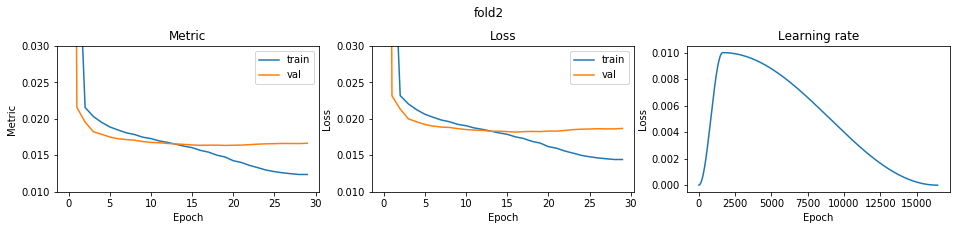

fold 3


epoch1 save best model... 0.22960192288923373
epoch2 save best model... 0.021079182153851947
epoch3 save best model... 0.01924172020591541
epoch4 save best model... 0.018403520802956642
epoch5 save best model... 0.017949666985754
epoch6 save best model... 0.01766870588123595
epoch7 save best model... 0.017575551462115757
epoch8 save best model... 0.017464214225632727
epoch9 save best model... 0.017159091074927656
epoch10 save best model... 0.017075290588199548
epoch11 save best model... 0.016975801668484145
epoch12 save best model... 0.016866346259849625
epoch13 save best model... 0.016801357091084157
epoch15 save best model... 0.0167555157905593
epoch16 save best model... 0.016636976135092744
epoch17 save best model... 0.01662610649833443
epoch18 save best model... 0.016617238521575928
epoch19 save best model... 0.016543740380750564
epoch20 save best model... 0.016486462612545164
fold3 score: 0.016486462444218856


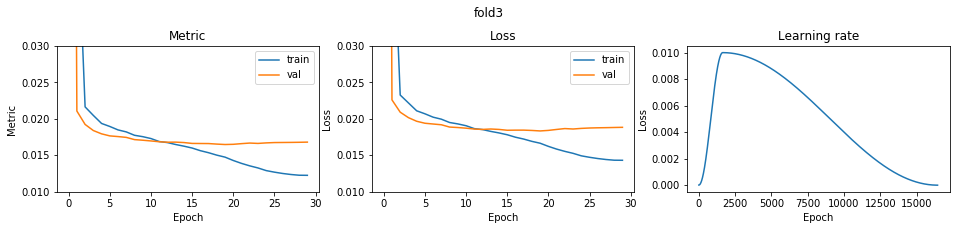

fold 4


epoch1 save best model... 0.244895599168091
epoch2 save best model... 0.020303423141801818
epoch3 save best model... 0.01880430615335228
epoch4 save best model... 0.018267542941406676
epoch5 save best model... 0.01773535072345261
epoch6 save best model... 0.01742898994602755
epoch7 save best model... 0.017351431839999685
epoch8 save best model... 0.01729743615607466
epoch9 save best model... 0.017146319624011093
epoch10 save best model... 0.01694660370401478
epoch11 save best model... 0.01689438636421071
epoch12 save best model... 0.016779260029740513
epoch14 save best model... 0.016678974940812805
epoch15 save best model... 0.01661465165453511
epoch16 save best model... 0.016527940572190664
epoch19 save best model... 0.016499496810138226
fold4 score: 0.016499496659074707


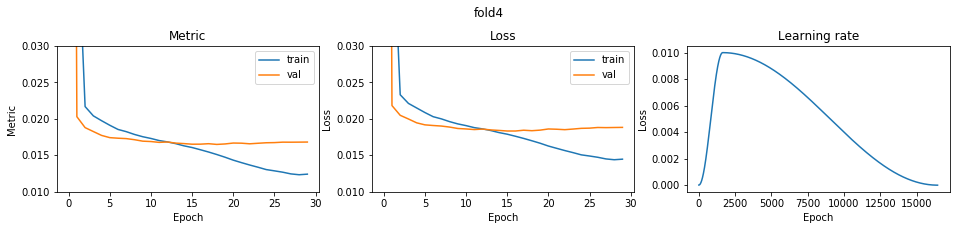

CV score: 0.016424800578819454

optimizer: RangerQH
fold 0


epoch1 save best model... 0.045529088769999074
epoch2 save best model... 0.03173726887223661
fold0 score: 0.03173726872031257


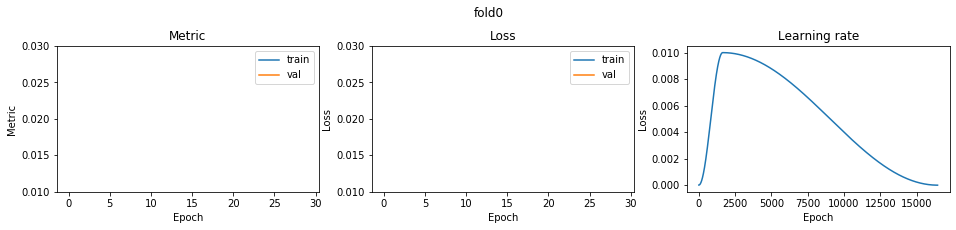

fold 1


epoch1 save best model... 0.04461526154358204
epoch2 save best model... 0.03161299883585961
fold1 score: 0.0316129988686055


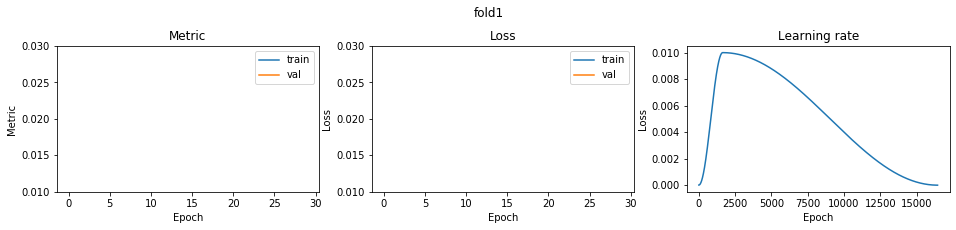

fold 2


epoch1 save best model... 0.04479439638590699
epoch2 save best model... 0.03140207000015659
fold2 score: 0.03140207019746226


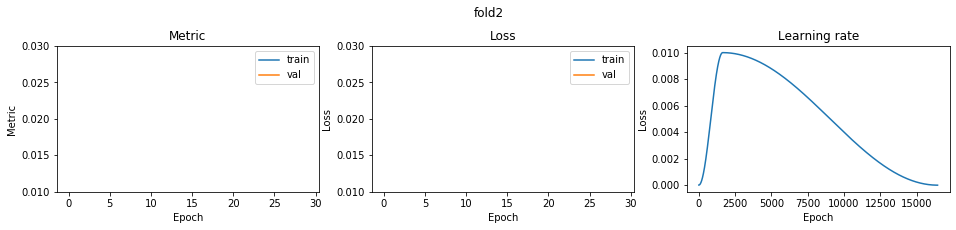

fold 3


epoch1 save best model... 0.045803488078177114
epoch2 save best model... 0.03156764306348657
fold3 score: 0.031567643013180616


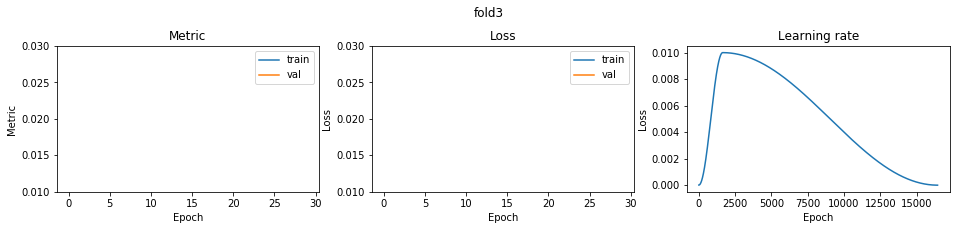

fold 4


epoch1 save best model... 0.0459358423184561
epoch2 save best model... 0.031337720141289986
fold4 score: 0.03133772004952855


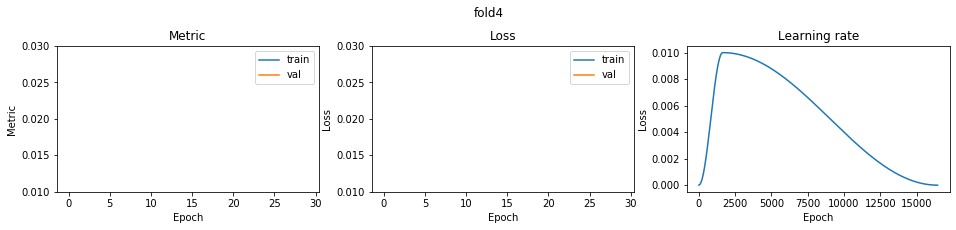

CV score: 0.03153154235731897

optimizer: RangerVA
fold 0


epoch1 save best model... 0.6978281460210239
epoch2 save best model... 0.39023628663908105
epoch3 save best model... 0.03343142407664134
epoch4 save best model... 0.023361697933023503
epoch5 save best model... 0.02157286758914352
epoch6 save best model... 0.020873770573450114
epoch7 save best model... 0.020403534136627693
epoch8 save best model... 0.020088881090419168
epoch9 save best model... 0.019871804999836755
epoch10 save best model... 0.019638836354119088
epoch11 save best model... 0.019441230845444565
epoch12 save best model... 0.019297735107922608
epoch13 save best model... 0.01911973028628321
epoch14 save best model... 0.018994418746348395
epoch15 save best model... 0.018901790180381448
epoch16 save best model... 0.018794472902538023
epoch17 save best model... 0.018711056416866993
epoch18 save best model... 0.01869269669785722
epoch19 save best model... 0.0185884985410882
epoch20 save best model... 0.018546582462270332
epoch22 save best model... 0.018504849660097872
epoch23 sa

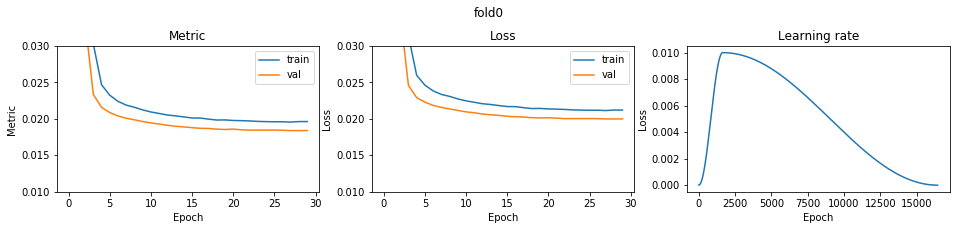

fold 1


epoch1 save best model... 0.6952933615447449
epoch2 save best model... 0.37897326092590744
epoch3 save best model... 0.03281400622543237
epoch4 save best model... 0.023333154346282078
epoch5 save best model... 0.021621570115457855
epoch6 save best model... 0.02089779785738553
epoch7 save best model... 0.020598294055965718
epoch8 save best model... 0.020143140746523725
epoch9 save best model... 0.019900582285585614
epoch10 save best model... 0.019690738134060668
epoch11 save best model... 0.019435953165114428
epoch12 save best model... 0.01928373787269475
epoch13 save best model... 0.0191338352203763
epoch14 save best model... 0.01899568897396781
epoch15 save best model... 0.01887636735447992
epoch16 save best model... 0.018792163302256595
epoch17 save best model... 0.01874155745820131
epoch18 save best model... 0.018681695273132876
epoch19 save best model... 0.018622751794814874
epoch20 save best model... 0.018599182290085954
epoch21 save best model... 0.01852723396253575
epoch23 save 

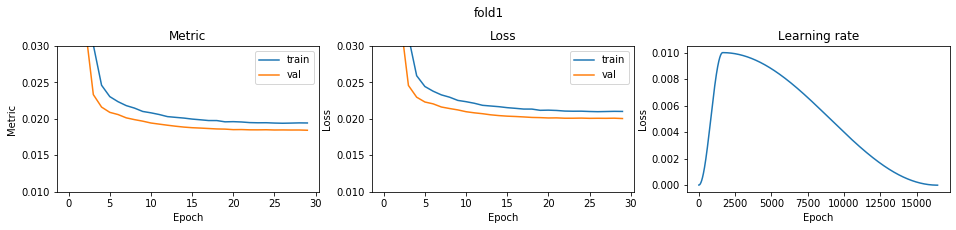

fold 2


epoch1 save best model... 0.6953592902844303
epoch2 save best model... 0.3795699353885151
epoch3 save best model... 0.03314103985340673
epoch4 save best model... 0.02338930190086541
epoch5 save best model... 0.021672066896525757
epoch6 save best model... 0.02087543372681891
epoch7 save best model... 0.020461446692410405
epoch8 save best model... 0.020189084280702405
epoch9 save best model... 0.019845586830287948
epoch10 save best model... 0.019634928175741133
epoch11 save best model... 0.019434707411147924
epoch12 save best model... 0.019270502484097354
epoch13 save best model... 0.01913984274730599
epoch14 save best model... 0.01900289060879396
epoch15 save best model... 0.0188946874120915
epoch16 save best model... 0.018773117434767308
epoch17 save best model... 0.018692909730362795
epoch18 save best model... 0.018586964358775743
epoch19 save best model... 0.018577829084392424
epoch20 save best model... 0.01852740693814487
epoch22 save best model... 0.018460498617927628
epoch24 save 

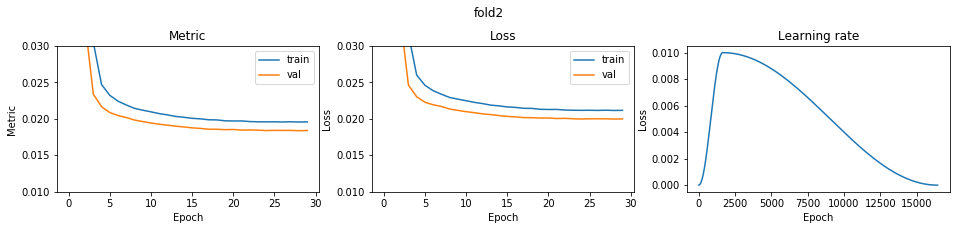

fold 3


epoch1 save best model... 0.6893117314047585
epoch2 save best model... 0.3713021365683823
epoch3 save best model... 0.032545630622799415
epoch4 save best model... 0.023456203048212925
epoch5 save best model... 0.021683702163890445
epoch6 save best model... 0.0210800826727733
epoch7 save best model... 0.020650209711359682
epoch8 save best model... 0.020302641409150154
epoch9 save best model... 0.020008282741883893
epoch10 save best model... 0.019825839003068575
epoch11 save best model... 0.01960471621067486
epoch12 save best model... 0.019425297215801572
epoch13 save best model... 0.019299319951640175
epoch14 save best model... 0.019138869788743774
epoch15 save best model... 0.019054474602273087
epoch16 save best model... 0.018978798239659474
epoch17 save best model... 0.01890077407605488
epoch18 save best model... 0.018797230026801382
epoch19 save best model... 0.01878814819504365
epoch20 save best model... 0.018717930594497362
epoch21 save best model... 0.018711985358735018
epoch22 sa

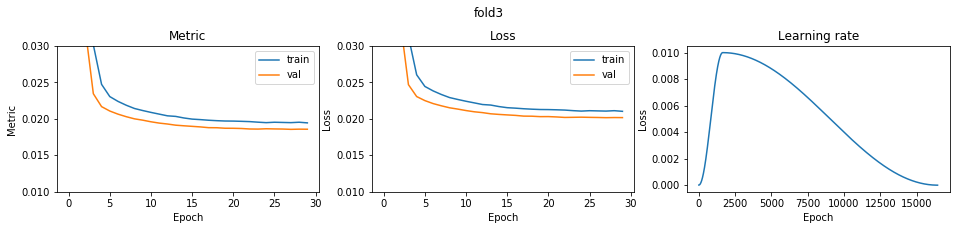

fold 4


epoch1 save best model... 0.6941272647342812
epoch2 save best model... 0.34240265879652765
epoch3 save best model... 0.0321459619366566
epoch4 save best model... 0.022989902192204852
epoch5 save best model... 0.021350854479947504
epoch6 save best model... 0.020593915878877826
epoch7 save best model... 0.020295989141716774
epoch8 save best model... 0.019829762019301873
epoch9 save best model... 0.01959737658857077
epoch10 save best model... 0.019340487667157874
epoch11 save best model... 0.01915920883977196
epoch12 save best model... 0.019050057027870812
epoch13 save best model... 0.01894213984760717
epoch14 save best model... 0.018788292236914667
epoch15 save best model... 0.01873434172913534
epoch16 save best model... 0.018610797881027832
epoch17 save best model... 0.01855423138275369
epoch18 save best model... 0.01847356988927498
epoch19 save best model... 0.01844246869987399
epoch20 save best model... 0.01842288053880927
epoch21 save best model... 0.018351071454363967
epoch23 save b

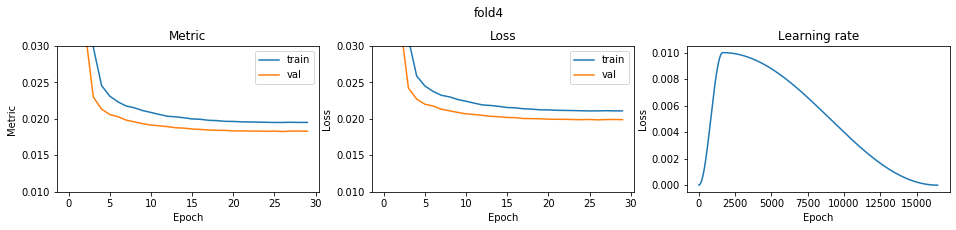

CV score: 0.018411492470814653

optimizer: SWATS
fold 0


epoch1 save best model... 0.07239351613714375
epoch2 save best model... 0.03116830590187417
fold0 score: 0.031168306033097424


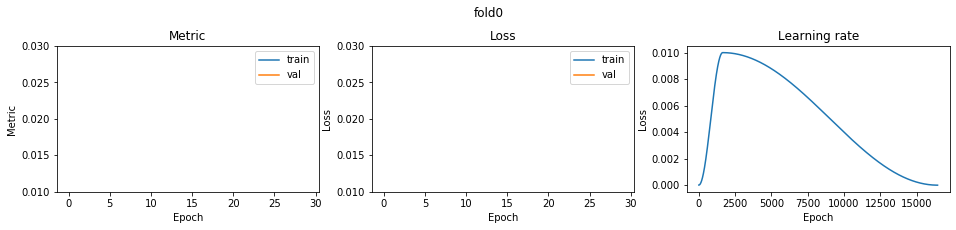

fold 1


epoch1 save best model... 0.07194594378880419
epoch2 save best model... 0.030847253519375412
fold1 score: 0.030847253561664217


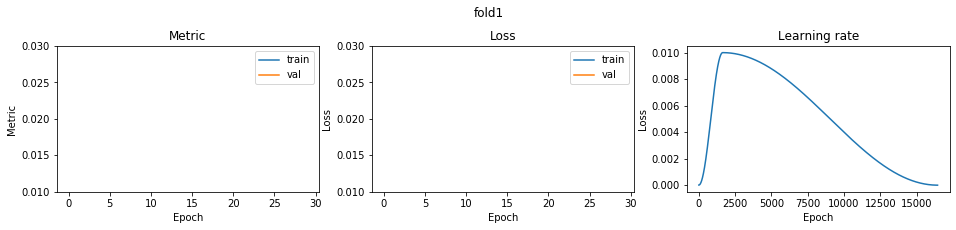

fold 2


epoch1 save best model... 0.07107954314260771
epoch2 save best model... 0.03119020624348109
fold2 score: 0.031190206265837937


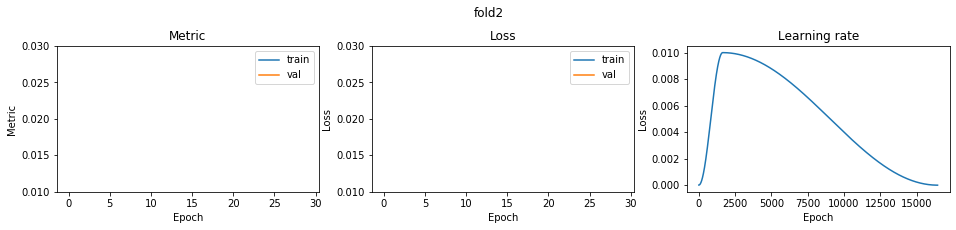

fold 3


epoch1 save best model... 0.07219137763583307
epoch2 save best model... 0.03110665838766614
fold3 score: 0.031106658473270588


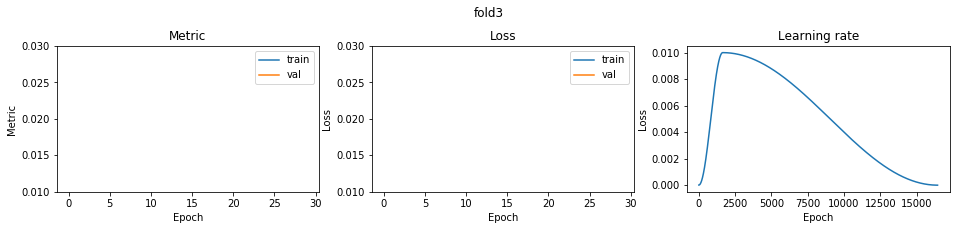

fold 4


epoch1 save best model... 0.07371135805489533
epoch2 save best model... 0.031032295671030708
fold4 score: 0.031032295629722557


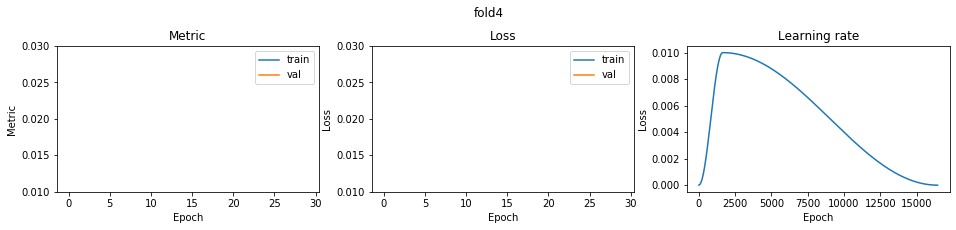

CV score: 0.03106894856845018

optimizer: Yogi
fold 0


epoch1 save best model... 0.09114928447507781
epoch2 save best model... 0.030869171451055923
fold0 score: 0.03086917151853117


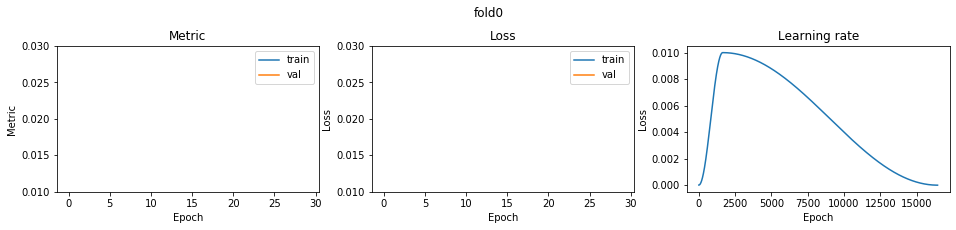

fold 1


epoch1 save best model... 0.0909839471894208
epoch2 save best model... 0.030869571700451123
fold1 score: 0.030869571698123485


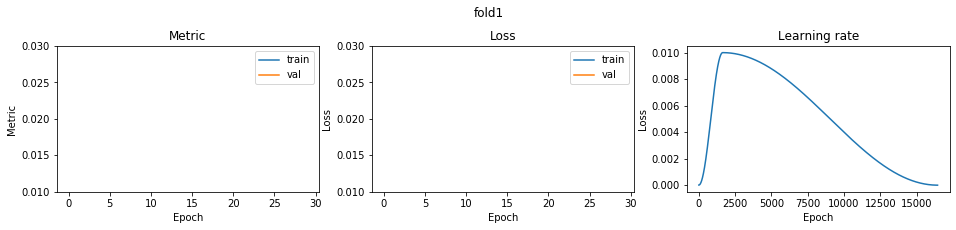

fold 2


epoch1 save best model... 0.09389325036943352
epoch2 save best model... 0.03098501547904527
fold2 score: 0.03098501552533893


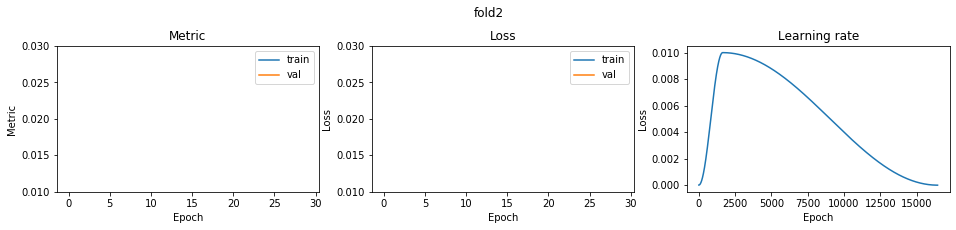

fold 3


epoch1 save best model... 0.09473503783243392
epoch2 save best model... 0.031325123933460014
fold3 score: 0.03132512397896636


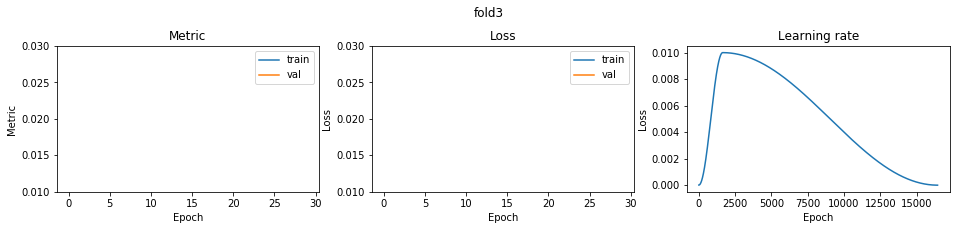

fold 4


epoch1 save best model... 0.09172107350921305
epoch2 save best model... 0.031115137940964287
fold4 score: 0.031115138160101558


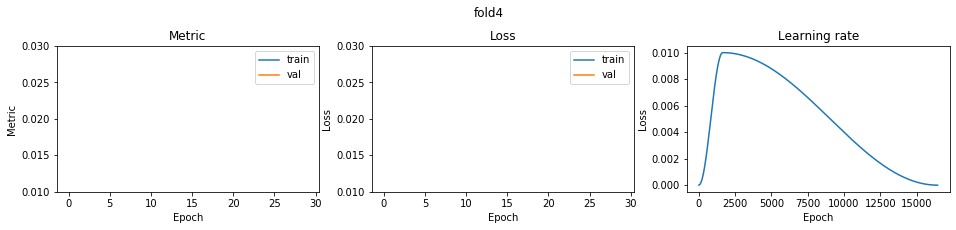

CV score: 0.031032813790807204

optimizer: Adam
fold 0


epoch1 save best model... 0.03388660777029252
epoch2 save best model... 0.032019004622868906
epoch7 save best model... 0.03188595008741479
epoch13 save best model... 0.03182271405341685
epoch15 save best model... 0.0314656491228008
fold0 score: 0.03146565020633493


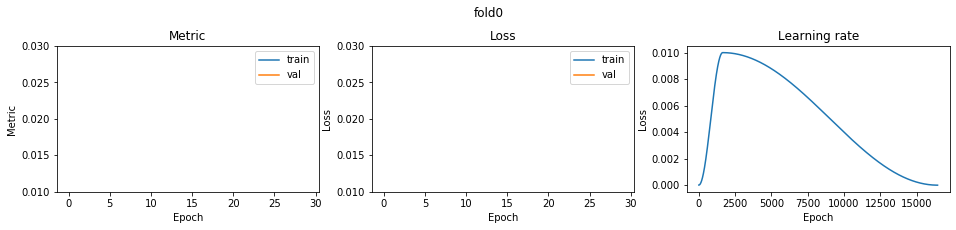

fold 1


epoch1 save best model... 0.034082396750801595
epoch2 save best model... 0.03161369184255736
fold1 score: 0.031613691968359045


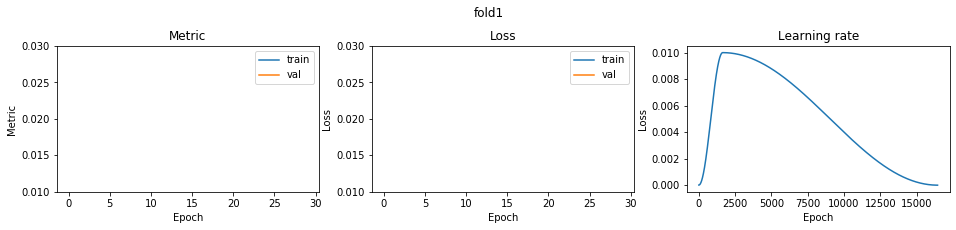

fold 2


epoch1 save best model... 0.034195295390098995
epoch2 save best model... 0.03194765948984788
epoch11 save best model... 0.03178322598665756
epoch13 save best model... 0.03177497205811458
fold2 score: 0.03177497366742641


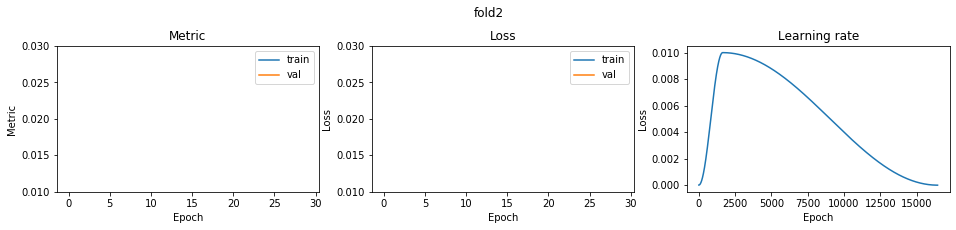

fold 3


epoch1 save best model... 0.03472115802313445
epoch2 save best model... 0.03220387879920304
epoch12 save best model... 0.03209499143369513
epoch14 save best model... 0.03192567238011366
fold3 score: 0.03192567287238866


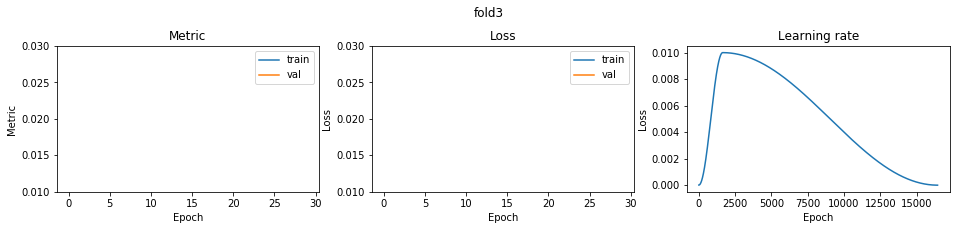

fold 4


epoch1 save best model... 0.03396215897078938
epoch2 save best model... 0.031488228037715775
fold4 score: 0.031488228038951724


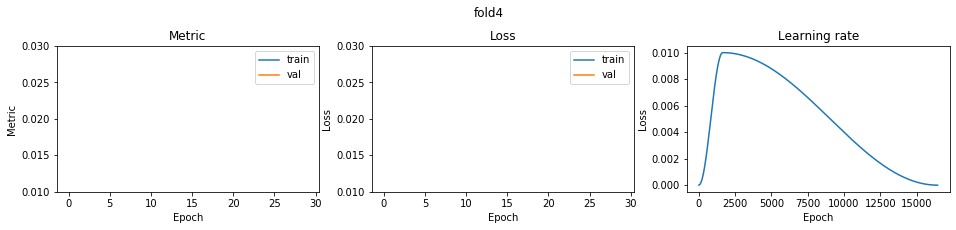

CV score: 0.03165363964288577

optimizer: LookaheadAdam
fold 0


epoch1 save best model... 0.04408911385304021
epoch2 save best model... 0.031770426309869065
epoch10 save best model... 0.03167414907663042
epoch14 save best model... 0.031672567345524434
fold0 score: 0.03167256631286678


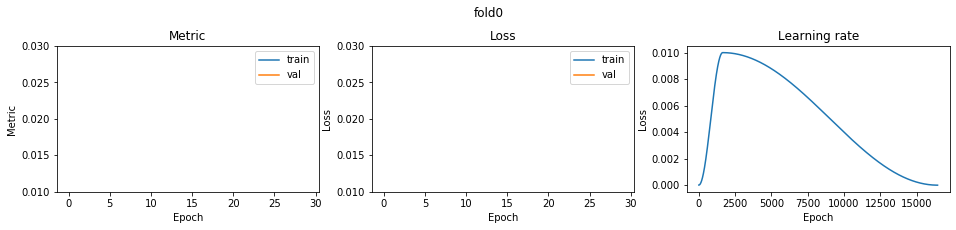

fold 1


epoch1 save best model... 0.044149376811851375
epoch2 save best model... 0.03167541170020423
fold1 score: 0.03167541171787376


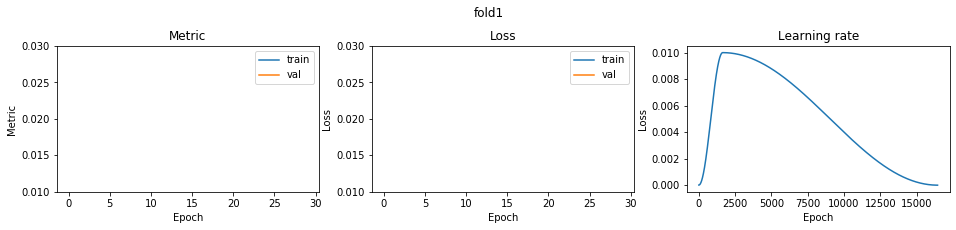

fold 2


epoch1 save best model... 0.04258381412040946
epoch2 save best model... 0.03151763446661301
fold2 score: 0.03151763439821348


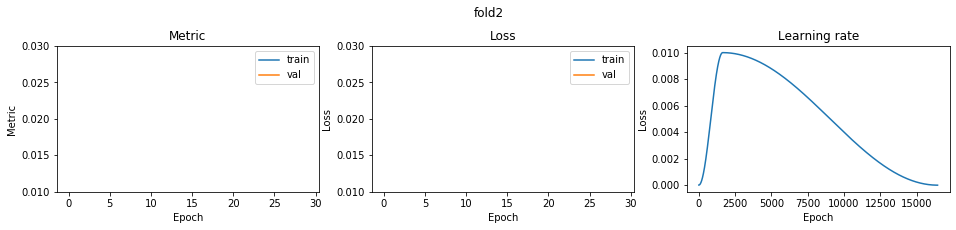

fold 3


epoch1 save best model... 0.0429432571850768
epoch2 save best model... 0.0314483871704693
fold3 score: 0.031448387267536716


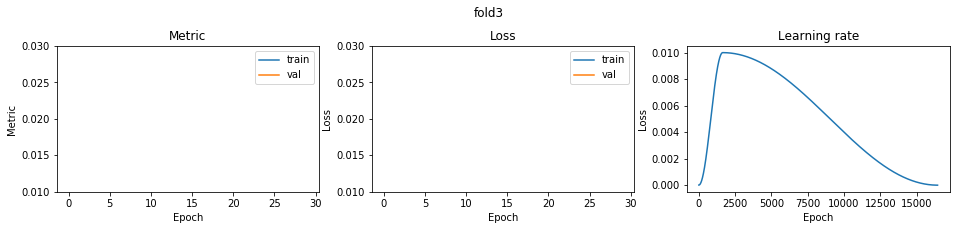

fold 4


epoch1 save best model... 0.043906963221168736
epoch2 save best model... 0.03143705488999368
fold4 score: 0.03143705478724885


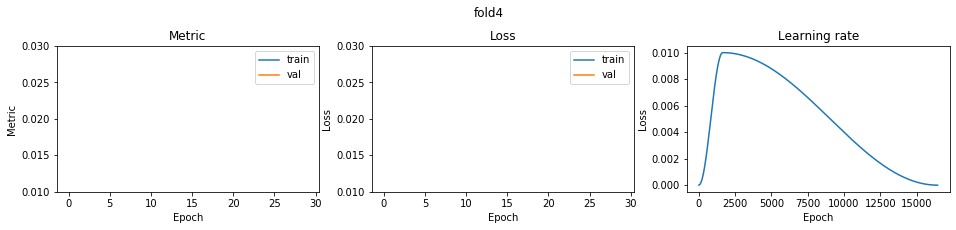

CV score: 0.03155020667657648

optimizer: LookaheadDiffGrad
fold 0


epoch1 save best model... 0.18430358402957134
epoch2 save best model... 0.03276451526035752
epoch3 save best model... 0.031208118675000847
fold0 score: 0.031208118508619615


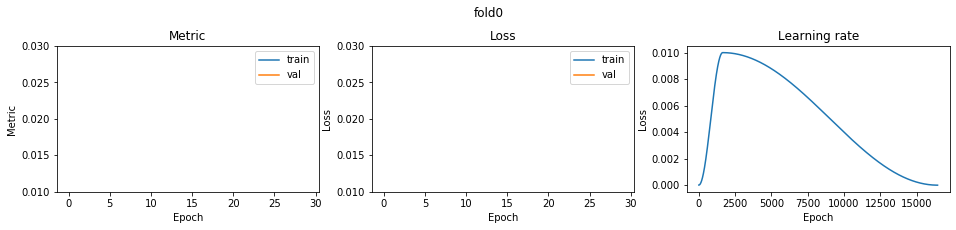

fold 1


epoch1 save best model... 0.17851334692785967
epoch2 save best model... 0.03288401084436211
epoch3 save best model... 0.03127005027798483
fold1 score: 0.031270050289571236


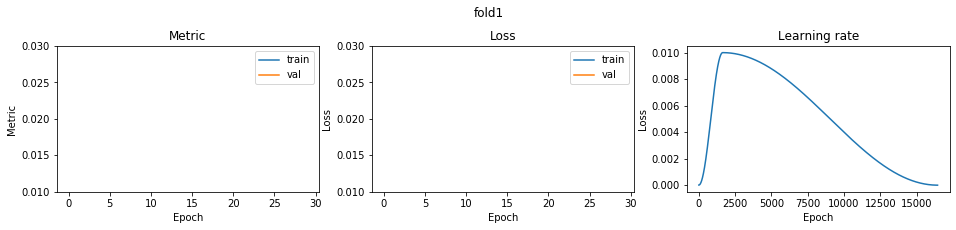

fold 2


epoch1 save best model... 0.1729839115037981
epoch2 save best model... 0.033140658559037875
epoch3 save best model... 0.0313323208038167
fold2 score: 0.031332320782272056


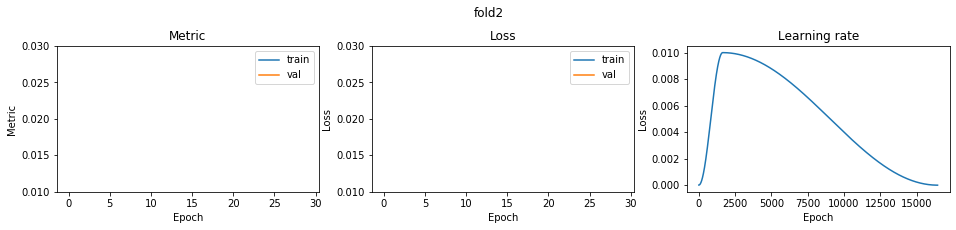

fold 3


epoch1 save best model... 0.17265646934916598
epoch2 save best model... 0.03283439419128357
epoch3 save best model... 0.0314736967078985
fold3 score: 0.031473696679914114


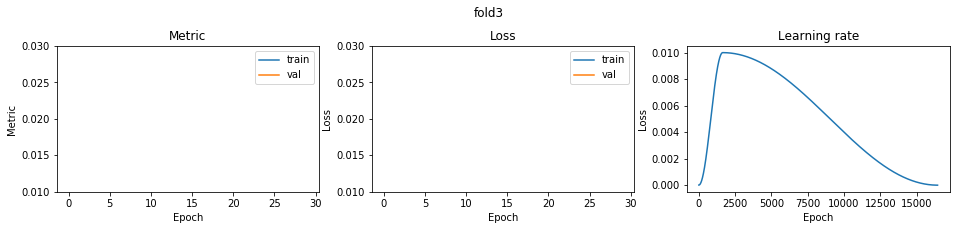

fold 4


epoch1 save best model... 0.17537795534030723
epoch2 save best model... 0.032907435553390235
epoch3 save best model... 0.031102039479992113
fold4 score: 0.03110203945977476


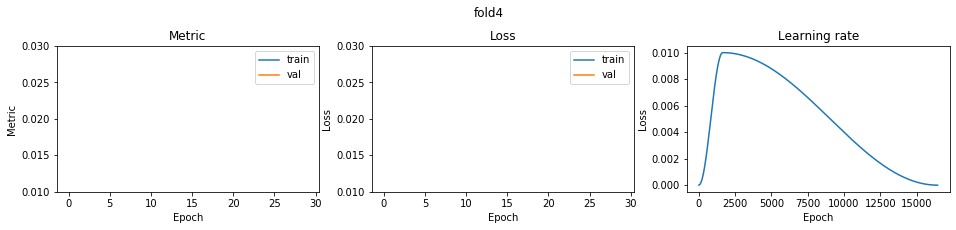

CV score: 0.03127724296247469

optimizer: LookaheadYogi
fold 0


epoch1 save best model... 0.47173017191452427
epoch2 save best model... 0.03079899762224635
fold0 score: 0.030798997636411588


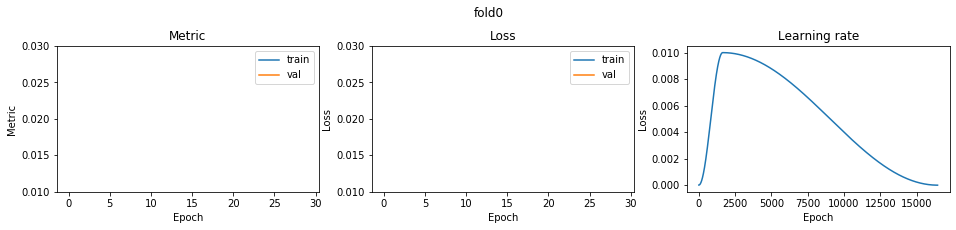

fold 1


epoch1 save best model... 0.47145292996735527
epoch2 save best model... 0.030872560966243013
fold1 score: 0.03087256109059899


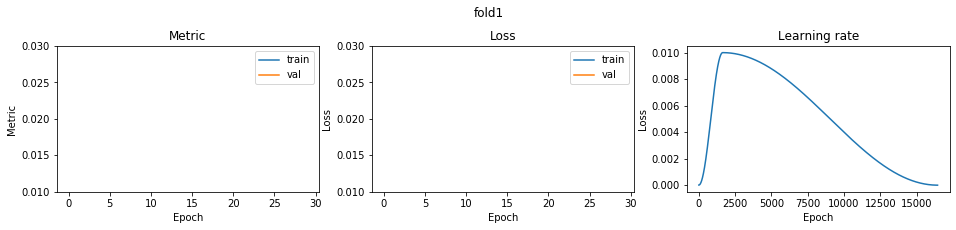

fold 2


epoch1 save best model... 0.4843931856365078
epoch2 save best model... 0.030941969460212958
fold2 score: 0.030941969564013485


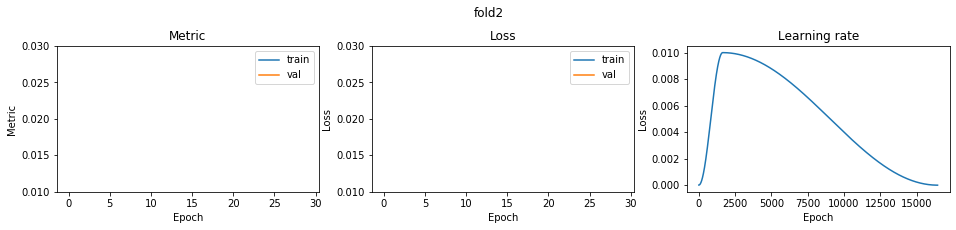

fold 3


epoch1 save best model... 0.4801849883482505
epoch2 save best model... 0.031135215139300784
fold3 score: 0.031135215072785775


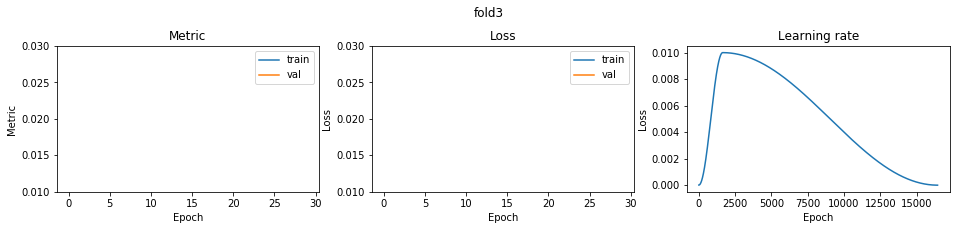

fold 4


epoch1 save best model... 0.4800885842981534
epoch2 save best model... 0.030984305218710716
epoch3 save best model... 0.030926821467409372
fold4 score: 0.03092682137039905


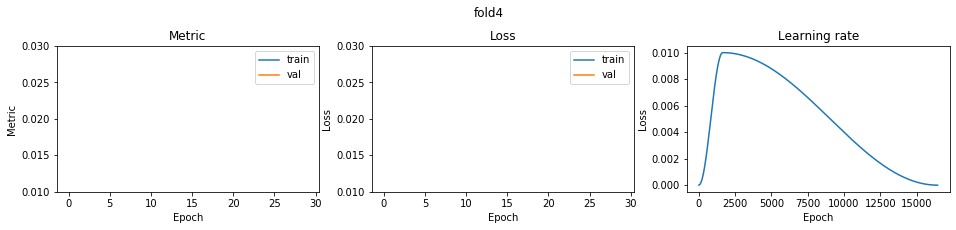

CV score: 0.03093511548444152

optimizer: LookaheadAdamW
fold 0


epoch1 save best model... 0.03304222019427458
epoch2 save best model... 0.019757993717026603
epoch3 save best model... 0.018548091231147357
epoch4 save best model... 0.017961646521417317
epoch5 save best model... 0.01764694561159285
epoch6 save best model... 0.01719947142912614
epoch7 save best model... 0.017148622423240698
epoch8 save best model... 0.017046506345645442
epoch9 save best model... 0.016855788788416662
epoch10 save best model... 0.01670747809451506
epoch11 save best model... 0.016652357343219407
epoch12 save best model... 0.01655263028410953
epoch13 save best model... 0.01652518914490599
epoch14 save best model... 0.01646473622861783
epoch15 save best model... 0.016416244622922432
epoch16 save best model... 0.016381219221206895
epoch17 save best model... 0.016329292985260622
epoch18 save best model... 0.016245075507017367
epoch21 save best model... 0.016238408026567626
fold0 score: 0.01623840781768346


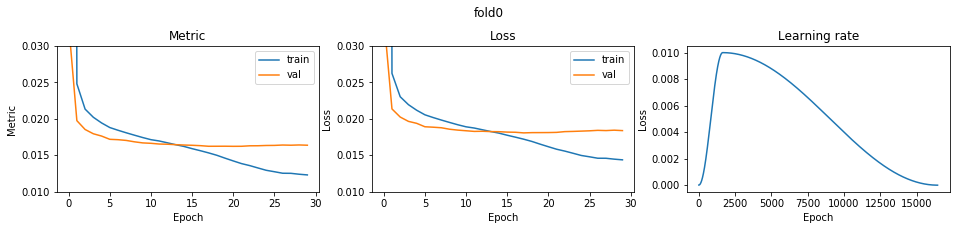

fold 1


epoch1 save best model... 0.031563099824260483
epoch2 save best model... 0.020165179752358327
epoch3 save best model... 0.01938619481526548
epoch4 save best model... 0.018145614262694894
epoch5 save best model... 0.01793948755323493
epoch6 save best model... 0.017510193455467792
epoch7 save best model... 0.017363668091155506
epoch9 save best model... 0.01703788762104541
epoch11 save best model... 0.01690953478385183
epoch12 save best model... 0.016788694753777766
epoch14 save best model... 0.01675198022123383
epoch16 save best model... 0.01671366540999015
epoch17 save best model... 0.01663239027029101
epoch18 save best model... 0.016589206133498693
epoch19 save best model... 0.01656793131083284
fold1 score: 0.01656793111104512


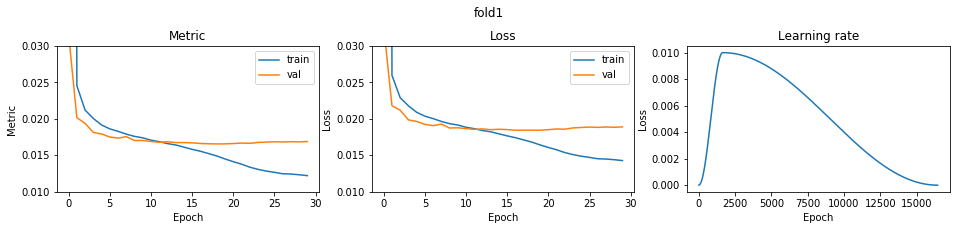

fold 2


epoch1 save best model... 0.0329947853620054
epoch2 save best model... 0.02015245865752904
epoch3 save best model... 0.01861796765589285
epoch4 save best model... 0.018107454506156247
epoch5 save best model... 0.01777703526917243
epoch6 save best model... 0.01735356297088487
epoch7 save best model... 0.017203387061011332
epoch8 save best model... 0.01712059521868122
epoch9 save best model... 0.016866673650481036
epoch10 save best model... 0.01680796025021693
epoch11 save best model... 0.01678594374084091
epoch12 save best model... 0.0165897588143505
epoch15 save best model... 0.016440160828435656
epoch16 save best model... 0.016399640811059355
epoch19 save best model... 0.01632393847117156
fold2 score: 0.016323938361447573


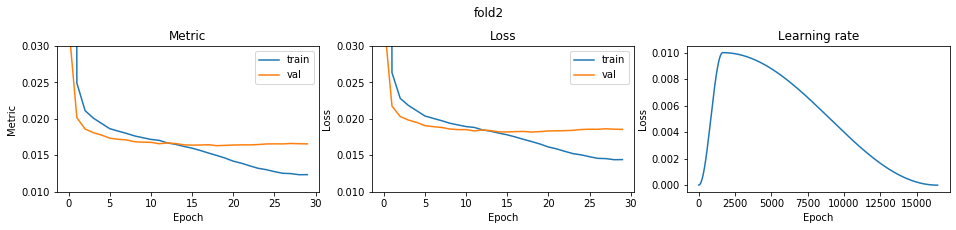

fold 3


epoch1 save best model... 0.0339701903436613
epoch2 save best model... 0.020194394424438884
epoch3 save best model... 0.018842209808121103
epoch4 save best model... 0.018225010320255725
epoch5 save best model... 0.01802381269404652
epoch6 save best model... 0.0175506544602793
epoch7 save best model... 0.017376846106031355
epoch9 save best model... 0.01716954880744083
epoch10 save best model... 0.017056129327582742
epoch11 save best model... 0.016935884541829788
epoch12 save best model... 0.016749679090153926
epoch13 save best model... 0.0167472730859571
epoch14 save best model... 0.016629703589428665
epoch15 save best model... 0.01658497387225101
epoch16 save best model... 0.016532691002553987
epoch18 save best model... 0.01648390048261995
epoch19 save best model... 0.016431514636649495
fold3 score: 0.016431514622465008


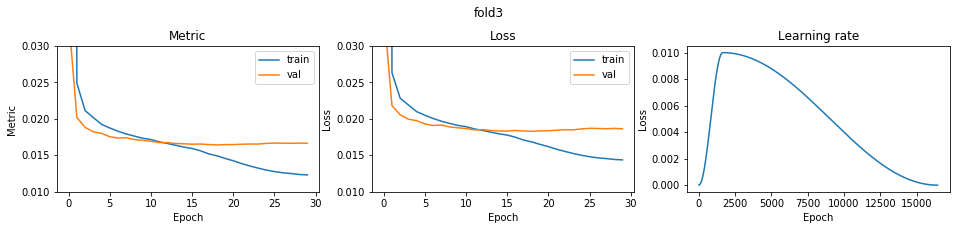

fold 4


epoch1 save best model... 0.03129185499678576
epoch2 save best model... 0.019599774167586567
epoch3 save best model... 0.018364711751172783
epoch4 save best model... 0.01789726627596011
epoch5 save best model... 0.017695400577488276
epoch6 save best model... 0.017329273172198095
epoch7 save best model... 0.017246940336985712
epoch8 save best model... 0.01720827399733941
epoch9 save best model... 0.017017411055353072
epoch10 save best model... 0.016790199031998194
epoch13 save best model... 0.016744247852805535
epoch14 save best model... 0.016570847242612367
epoch15 save best model... 0.016569478643935064
epoch16 save best model... 0.016511843538925833
epoch19 save best model... 0.016460150246485082
fold4 score: 0.016460150132906654


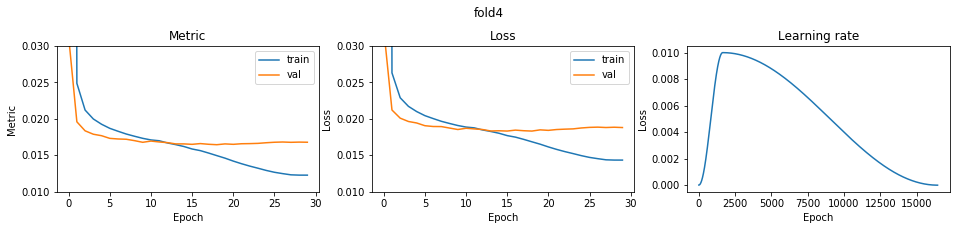

CV score: 0.01640438462322227


In [23]:
score_dict = {}

for optimizer in optim_list:
    CFG.optimizer = optimizer
    logger.info('')
    logger.info('optimizer: '+ optimizer.__name__)
    oof, predictions = run_kfold_nn(CFG,
                                    trn_df,
                                    test_df,
                                    CFG.feature_cols,
                                    CFG.target_cols,
                                    n_fold=5)

    # OOF score without 'ctl_vehicle'
    ys = trn_df[y_keys]
    preds = oof

    score = compute_metric(preds, ys)
    score_dict[optimizer.__name__] = score

In [24]:
logger.info(pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index')

                     metric
Adam_CG            0.031635
AdamW_CG           0.016427
PlainRAdam_CG      0.019701
RAdam_CG           0.016404
Ranger_CG          0.016434
AdaBelief          0.016427
AdaBound           0.030099
AdaMod             0.016408
AdamW              0.016404
AdamP              0.016378
DiffGrad           0.031365
Lamb               0.016473
NovoGrad           0.016279
PlainRAdam         0.016404
QHAdam             0.031714
RAdam              0.016409
Ranger             0.016425
RangerQH           0.031532
RangerVA           0.018411
SWATS              0.031069
Yogi               0.031033
Adam               0.031654
LookaheadAdam      0.031550
LookaheadDiffGrad  0.031277
LookaheadYogi      0.030935
LookaheadAdamW     0.016404


metric
Adam_CG            0.031635
AdamW_CG           0.016427
PlainRAdam_CG      0.019701
RAdam_CG           0.016404
Ranger_CG          0.016434
AdaBelief          0.016427
AdaBound           0.030099
AdaMod             0.016408
AdamW              0.016404
AdamP              0.016378
DiffGrad           0.031365
Lamb               0.016473
NovoGrad           0.016279
PlainRAdam         0.016404
QHAdam             0.031714
RAdam              0.016409
Ranger             0.016425
RangerQH           0.031532
RangerVA           0.018411
SWATS              0.031069
Yogi               0.031033
Adam               0.031654
LookaheadAdam      0.031550
LookaheadDiffGrad  0.031277
LookaheadYogi      0.030935
LookaheadAdamW     0.016404

In [25]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

                     metric
NovoGrad           0.016279
AdamP              0.016378
PlainRAdam         0.016404
AdamW              0.016404
LookaheadAdamW     0.016404
RAdam_CG           0.016404
AdaMod             0.016408
RAdam              0.016409
Ranger             0.016425
AdamW_CG           0.016427
AdaBelief          0.016427
Ranger_CG          0.016434
Lamb               0.016473
RangerVA           0.018411
PlainRAdam_CG      0.019701
AdaBound           0.030099
LookaheadYogi      0.030935
Yogi               0.031033
SWATS              0.031069
LookaheadDiffGrad  0.031277
DiffGrad           0.031365
RangerQH           0.031532
LookaheadAdam      0.031550
Adam_CG            0.031635
Adam               0.031654
QHAdam             0.031714


metric
NovoGrad           0.016279
AdamP              0.016378
PlainRAdam         0.016404
AdamW              0.016404
LookaheadAdamW     0.016404
RAdam_CG           0.016404
AdaMod             0.016408
RAdam              0.016409
Ranger             0.016425
AdamW_CG           0.016427
AdaBelief          0.016427
Ranger_CG          0.016434
Lamb               0.016473
RangerVA           0.018411
PlainRAdam_CG      0.019701
AdaBound           0.030099
LookaheadYogi      0.030935
Yogi               0.031033
SWATS              0.031069
LookaheadDiffGrad  0.031277
DiffGrad           0.031365
RangerQH           0.031532
LookaheadAdam      0.031550
Adam_CG            0.031635
Adam               0.031654
QHAdam             0.031714

In [26]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index').to_csv(nb_name[:-6]+'.csv')